# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
import random
import pandas as pd
import random
import pickle
from collections import defaultdict
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import chi2, norm, gumbel_r, pearsonr
from tqdm import tqdm  # Import progress bar


# Data Generating Process

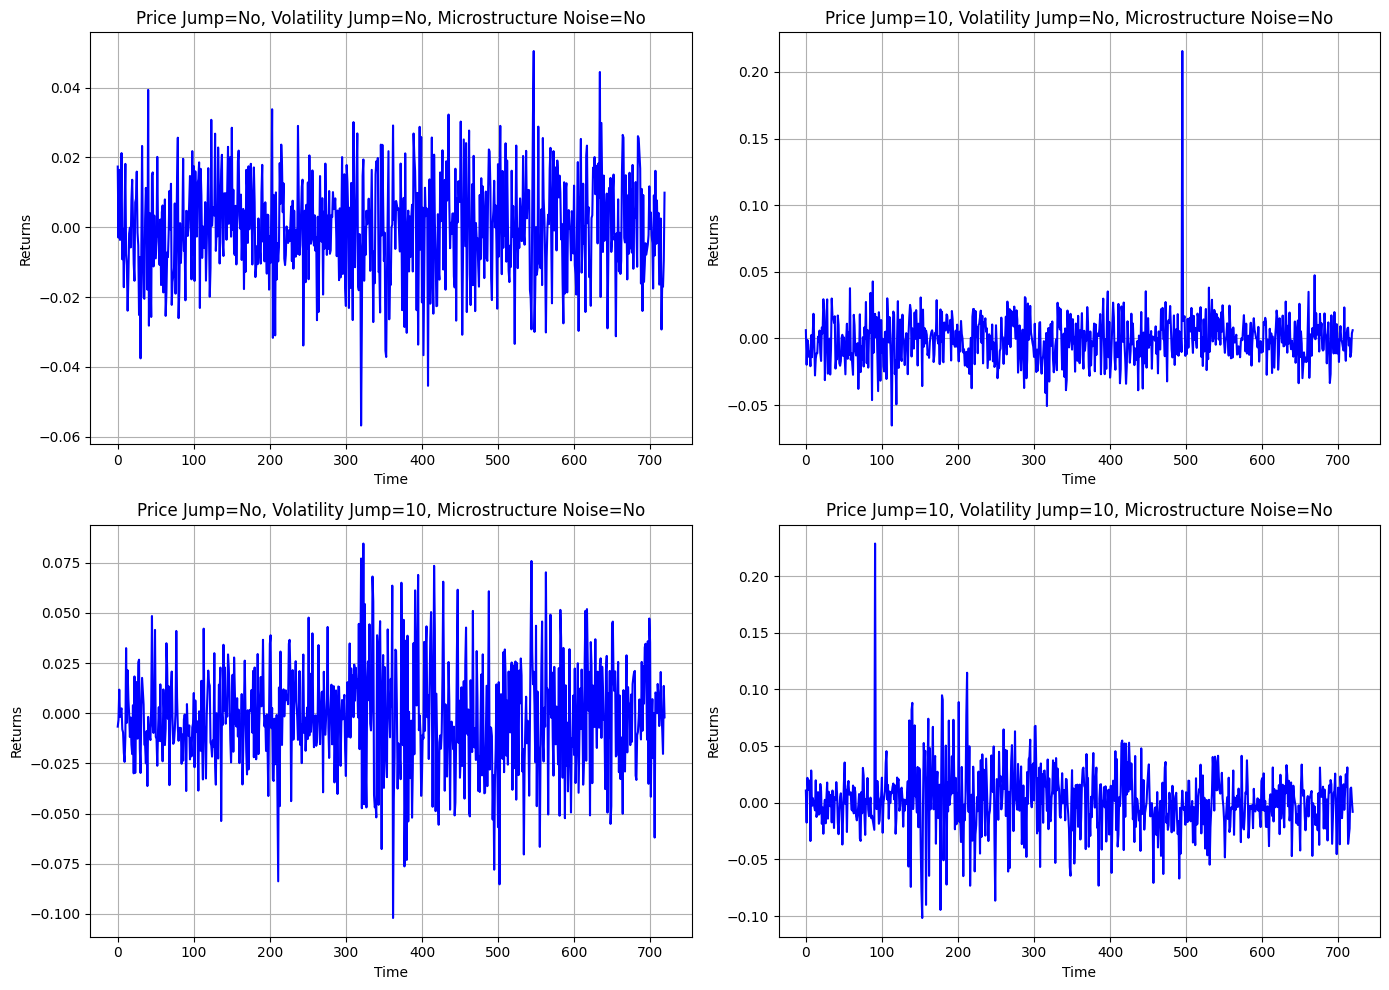

In [22]:
np.random.seed(10)
class DGP:
    def __init__(self, mu, kappa, rho, theta, sigma_v, sec, price_jump, volatility_jump, noise):
        self.mu = mu #drift
        self.kappa = kappa #speed of adjustment to the long run mean
        self.rho = rho #correlation between the Brownian increments
        self.theta = theta #long run mean
        self.sigma_v = sigma_v #volatility of the diffusion part
        self.sec = sec #frequency
        self.price_jump = price_jump #size of price jump
        self.volatility_jump = volatility_jump #size of volatility jump
        self.noise = noise #microstructure noise component
        self.dt = 1 / 21600 #time steps, 6 hours of open trading on stock market

    def generate_data(self):
        ######################### Heston model ############################################
        ## Generate multivariate normal variables with correlation parameter (2 vectors)
        W = np.random.multivariate_normal(mean=[0, 0],
                                          cov=[[self.dt, self.dt * self.rho], [self.dt * self.rho, self.dt]],
                                          size=21600)
        ## Generate the volatility process
        v = np.zeros(21600) #create placeholder for volatility process
        v[0] = self.theta #diffusive variance process is initialized at theta
        
        ## Volatility jump construction
        vj_loc = np.random.randint(0, 21600) #generate a random volatility jump time
        if self.volatility_jump != "No":
            jump_multiplier_v = int(self.volatility_jump)
            if 1 <= jump_multiplier_v <= 10:
                v[vj_loc] += jump_multiplier_v * self.theta

        for i in range(1, 21600):
            if i==vj_loc:
                v[i] = v[i - 1] + self.kappa * (self.theta - v[i - 1]) * self.dt + self.sigma_v * np.sqrt(v[i - 1]) * W[i, 0]+v[vj_loc]
                
            elif i!=vj_loc:
                v[i] = v[i - 1] + self.kappa * (self.theta - v[i - 1]) * self.dt + self.sigma_v * np.sqrt(v[i - 1]) * W[i, 0]
                
        ## Generate the returns
        r = np.zeros(21600) #create placeholder for price process
        for i in range(21600):
            r[i] = self.mu * self.dt + np.sqrt(v[i]) * W[i, 1]
    
        ## Price jump construction
        pj_loc = np.random.randint(0, 21600) #generate a random price jump time
        
        if self.price_jump != "No":
            jump_multiplier_p = int(self.price_jump)
            if 1 <= jump_multiplier_p <= 10:
                r[pj_loc] += jump_multiplier_p * np.sqrt(self.theta / 252)
                
        ########################## Microstrucure Noise #################################
        
        ## Generate noise as in Yacine Aït-Sahalia  Jean Jacodc, Jia Li (2012)
        if self.noise != "No":
            pass
            if self.noise == "Gaussian":
                nt = 2 * np.sqrt(self.dt * v) * np.random.normal(loc = 0.0, scale = 1.0, size = 21600)
                r = r + nt
            elif self.noise == "Student":
                df = 2.5
                nt = (2/np.sqrt(df/(df-2))) * np.sqrt(self.dt*v) * np.random.standard_t(df,21600)
                r = r + nt
        
        ####################### Poisson Jump Process ####################################
        
        ## Time grid
        T = 1
        dt = 1 / 21600
        n_steps = int(T / dt)
        time = np.linspace(0, T, n_steps)
        
        lambda_jump = 1.0 # Jump intensity (average jumps per year)
        mu_jump = 0.05    # Mean jump size
        sigma_jump = 0.1  # Std dev of jump size
        
        ## Poisson process for jumps
        N = np.random.poisson(lambda_jump * dt, n_steps)
        jump_sizes = np.random.normal(mu_jump, sigma_jump, n_steps) * N
        jumps = np.cumsum(jump_sizes)
            
        ######################## Aggregate returns #####################################
        
        ## Aggregate returns
        r = np.add.reduceat(r, np.arange(0, len(r), self.sec))
        return r
    
#See some examples
simulator_params = [
    {"price_jump": "No", "volatility_jump": "No", "noise": "No"},
    {"price_jump": "10", "volatility_jump": "No", "noise": "No"},
    {"price_jump": "No", "volatility_jump": "10", "noise": "No"},
    {"price_jump": "10", "volatility_jump": "10", "noise": "No"}
]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, params in enumerate(simulator_params):
    simulator = DGP(mu=0, kappa=5, rho=-0.5, theta=0.16, sigma_v=0.5, sec=30, **params)
    returns = simulator.generate_data()
    time = np.arange(0, len(returns))
    
    row = i // 2
    col = i % 2
    
    axs[row, col].plot(time, returns, color='blue')
    axs[row, col].set_title(f'Price Jump={params["price_jump"]}, Volatility Jump={params["volatility_jump"]}, Microstructure Noise={params["noise"]}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Returns')
    axs[row, col].grid(True)

plt.tight_layout()
#plt.savefig('simulated_returns.pdf')
plt.show()



# Simulation example

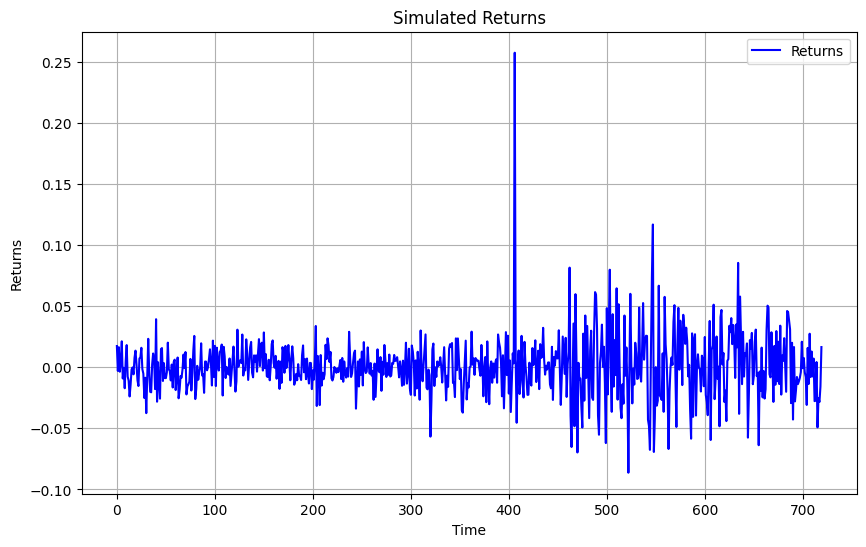

In [23]:
# Example usage
np.random.seed(10)
simulator = DGP(mu=0, kappa=5, rho=-0.5, theta=0.16, sigma_v=0.5, sec=30,
                              price_jump="10", volatility_jump="10", noise ="No")
returns = simulator.generate_data()

# Create a time array
time = np.arange(0, len(returns))

# Plot the returns
plt.figure(figsize=(10, 6))
#ax = plt.axes()
#ax.set_facecolor("grey")
plt.plot(time, returns, color='blue', label='Returns')
plt.title('Simulated Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()


# Realized Variance and Bipower Variation

Realized Variance: $RV_{t} = \sum_{i=1}^{M} r_{t_{i}}^{2},$
> where $r_{t_{i}} = p_{t_{i}} - p_{t_{i-1}}$ and $p_{t_{i}}$ is the logarithmic price process

Bipower Variation: $BV_{t} = \frac{\pi}{2} \left( \frac{M}{M-1} \right) \sum_{i=2}^{M} \lvert r_{t_{i}} \lvert \lvert r_{t_{i-1}} \lvert,$ 
> M equally-spaced returns observed

In [24]:
def realized_var(rt: np.array):
    RV = np.sum(np.power(rt, 2))
    return RV

def bipower_var(rt: np.array):
    M = len(rt)
    BV = (np.pi/2) * (M/(M-1)) * np.sum(np.abs(rt[1:]) * np.abs(rt[:-1]))
    return BV

## Tests based on Squared Variation

##### Barndorff-Nielsen and Shephard (2006) Test (BNS)

$T_{BNS,t} = \frac{1-\frac{BV_{t}}{RV_{t}}}{\sqrt{\left( (\frac{\pi}{2})^{2} + \pi - 5 \right) M^{-1} \max(1, \frac{TP_{t}}{BV_{t}^{2}})}} \xrightarrow[]{L} N(0,1) $

> $TP_{t} = \mu_{4/3}^{-3} \left( \frac{M^{2}}{M-2} \right)  \sum_{i=3}^{M} \lvert r_{t_{i-2}} \lvert^{4/3} \lvert r_{t_{i-1}} \lvert^{4/3} \lvert r_{t_{i}} \lvert^{4/3}$

> $\mu_{4/3} = 2^{2/3} \Gamma(7/6) \Gamma(1/2)^{-1}$

In [25]:
def BNS(rt: np.array):

    M = len(rt)
    RV = realized_var(rt)
    BV = bipower_var(rt)

    #constant = ((2**(2/3))*math.gamma(7/6)*(math.gamma(1/2)**(-1/2)))**(-3)
    constant = ((2**(2/3))*math.gamma(7/6)*(math.gamma(1/2)**(-1)))**(-3)
    
    temp = np.sum(np.abs(rt[:-2])**(4/3) * np.abs(rt[1:-1])**(4/3) * np.abs(rt[2:])**(4/3))
    TP = constant * (M**2/(M-2)) * temp
    
    numerator = 1 - (BV/RV)
    denumerator = np.sqrt(((np.pi/2)**2 + np.pi - 5) * M**(-1) * max(1, (TP/BV**2)))
    
    test = numerator / denumerator

    return test

##### Corsi, Pirino, and Reno (2010) Test (CPR)

$T_{CPR,t} = \frac{1-\frac{CTBV_{t}}{RV_{t}}}{\sqrt{\left( (\frac{\pi}{2})^{2} + \pi - 5 \right) M^{-1} max(1, \frac{CTriPV_{t}}{CTBV_{t}^{2}})}} \xrightarrow[]{L} N(0,1)$

>$CTBV_{t} = \frac{\pi}{2} \left( \frac{M}{M-1} \right) \sum_{i=2}^{M} \tau_{1,t_{i}}  \tau_{1,t_{i-1}}$

>$CTriPV_{t} = \mu_{4/3}^{-3} \left( \frac{M^{2}}{M-2} \right)  \sum_{i=3}^{M} \tau_{4/3 t_{i-2}}  \tau_{4/3 t_{i-1}}  \tau_{4/3 t_{i}}$

>$\tau_{1,t_{i}} = 
\begin{cases} 
\left| r_{t_i} \right| & \text{for } r_{t_i}^{2} < \upsilon_{t_i} \\
1.094 \sqrt{\upsilon_{t_i}} & \text{for } r_{t_i}^{2} > \upsilon_{t_i}
\end{cases}
$

>$\tau_{4/3,t_{i}} = 
\begin{cases} 
\left| r_{t_i} \right|^{4/3} & \text{for } r_{t_i}^{2} < \upsilon_{t_i} \\
1.129 \upsilon_{t_i}^{2/3} & \text{for } r_{t_i}^{2} > \upsilon_{t_i}
\end{cases}
$

In [26]:
def CPR(rt: np.array, K: int, c: int):
    
    M = len(rt)
    RV = realized_var(rt)
    
    temp = np.multiply(np.abs(rt[:-1]), np.abs(rt[1:]))
    Vti = np.zeros(M-K-1) #local variance estimator
    
    for i in range(M-K-1):
        Vti[i] = (np.pi/2) *(1/(K-1)) * np.sum(temp[i: i+K+1])
    
    psi = (c**2) * Vti #threshold nu
    r = rt[K+1:]
    
    tau1 = np.where(r <= np.sqrt(psi), np.abs(r), 1.094 * np.sqrt(psi))
    tau43 = np.where(r <= np.sqrt(psi), np.abs(r)**(4/3), 1.129 * psi**(2/3))
    
    Mn = len(tau1) 
    CTBV = (np.pi/2) * (Mn / (Mn-1)) * np.sum(tau1[:-1] * tau1[1:])
    
    #constant = ((2**(2/3))*math.gamma(7/6)*(math.gamma(1/2)**(-1/2)))**(-3)
    constant = ((2**(2/3))*math.gamma(7/6)*(math.gamma(1/2)**(-1)))**(-3)
    
    temp2 = np.sum(tau43[0:-2]*tau43[1:-1]*tau43[2:])
    CTPV = constant * (Mn**2 / (Mn-2)) * temp2
    
    numerator = 1 - (CTBV/RV)
    denumerator = ((np.pi/2)**2 + np.pi - 5) * (1/Mn) * max(1, CTPV/CTBV**2)
    
    test = numerator / np.sqrt(denumerator)
    
    return test

##### Andersen, Dobrev, and Schaumburg (2009) Tests Based on MinRV

$T_{MinRV,t} = \frac{1-\frac{MinRV_{t}}{RV_{t}}}{\sqrt{1.81 M^{-1} max(1, \frac{MinRQ_{t}}{MinRV_{t}^{2}})}} \xrightarrow[]{L} N(0,1)$

> $MinRV_{t} = \frac{\pi}{\pi-2} \left( \frac{M}{M-1} \right) \sum_{i=2}^{M} \min(|r_{t_{i}}|, |r_{t_{i-1}}|)^2$

> $MinRQ_{t} = \frac{\pi}{3\pi-8} \left( \frac{M^{2}}{M-1} \right) \sum_{i=2}^{M} \min(|r_{t_{i}}|, |r_{t_{i-1}}|)^4$



In [27]:
def TMIN(rt: np.array):  
    
    M = len(rt)
    RV = realized_var(rt)
    
    temp = np.minimum(np.abs(rt[1:]),np.abs(rt[:-1]))
    MinRV = (np.pi/(np.pi-2))*(M/(M-1)) * np.sum(temp**2) 
    MinRQ = (np.pi/(3*np.pi-8))* (M**2/(M-1)) * np.sum(temp**4)
    
    numerator = 1 - (MinRV/RV)
    denumerator = np.sqrt((1.81/M) * max(1,(MinRQ/(MinRV**2))))
    test = numerator / denumerator
    
    return test

##### Andersen, Dobrev, and Schaumburg (2009) Tests Based on MedRV

$T_{MedRV,t} = \frac{1-\frac{MedRV_{t}}{RV_{t}}}{\sqrt{0.96 M^{-1} max(1, \frac{MedRQ_{t}}{MedRV_{t}^{2}})}} \xrightarrow[]{L} N(0,1)$

> $MedRV_{t} =  \frac{\pi}{\pi+6-4\sqrt{3}} \left( \frac{M}{M-2} \right) \sum_{i=3}^{M} med(|r_{t_{i}}|, |r_{t_{i-1}}|, |r_{t_{i-2}}|)^2$

> $MedRQ_{t} =  \frac{3\pi}{9\pi+72-52\sqrt{3}} \left( \frac{M^{2}}{M-2} \right) \sum_{i=3}^{M} med(|r_{t_{i}}|, |r_{t_{i-1}}|, |r_{t_{i-2}}|)^4$

In [28]:
def TMED(rt: np.array):

    M = len(rt)
    RV = realized_var(rt)
    
    data_med = np.stack([np.abs(rt[0:M-2]), np.abs(rt[1:M-1]), np.abs(rt[2:])])
    constant_medrv = np.pi /(np.pi + 6 - 4*np.sqrt(3)) * (M/(M-2))
    MedRV = constant_medrv * np.sum(np.median(data_med, axis = 0)**2)
    
    constant_medrq = 3*np.pi/(9*np.pi + 72 - 52*np.sqrt(3)) * (M**2/(M-2))
    
    MedRQ = constant_medrq * np.sum(np.median(data_med,axis = 0)**4)
    
    numerator = 1 - (MedRV/RV)
    denumerator = np.sqrt(0.96/M *max(1,(MedRQ/MedRV**2)))
    test = numerator / denumerator
    
    return test

## Tests based on P-power Variation

##### Podolskij and Ziggel (2010) Test (Two variations)

$\displaystyle T_{PZ,t} = \frac{T(P,\Delta_{M})}{\sqrt{Var(\eta_{i}) M^{\frac{P}{2}-1} \sum_{i=1}^{M} \lvert r_{t_{i}} \lvert^{P} \mathbf{1}_{ \left\{ \lvert r_{t_{i}} \lvert < \sqrt \upsilon(\Delta_{M})^{\omega} \right\}}}} \xrightarrow{L} N(0,1)$

> $T(P,\Delta_{M}) = M^{\frac{P-1}{2}} \sum_{i=1}^{M} \lvert r_{t_{i}} \lvert^{P} \left( 1-\eta_{t_{i}} \mathbf{1}_{ \left\{ \lvert r_{t_{i}} \lvert < \sqrt \upsilon(\Delta_{M})^{\omega} \right\} } \right)$

> $E[\eta_{i}] = 1$ , $E[|\eta_{i}|^{2}]<\infty$

In [29]:
def PZ2(rt: np.array, tau: int):

    M = len(rt)
    BV = bipower_var(rt) 
    trunc = 2.3 * np.sqrt(BV) * ((1/M)**(0.4))
    
    unif = np.random.uniform(size = M)
    eta = np.where(unif <= 0.5, 1-tau, 1+tau)
    Bhat2 = np.sqrt(M) * np.sum(np.abs(rt)**2 * (1 - eta * np.where(np.abs(rt) < trunc, 1, 0)))
    Vbar4 = M * np.sum(np.where(np.abs(rt) < trunc,rt**4,0))
    var2 = np.var(eta, ddof = 1) * Vbar4  #Need to set degrees of freedom to 1
    
    test = Bhat2/np.sqrt(var2)
    
    return test

In [30]:
def PZ4(rt: np.array, tau: int):

    M = len(rt)
    BV = bipower_var(rt) 
    trunc = 2.3 * np.sqrt(BV) * ((1/M)**(0.4))

    unif = np.random.uniform(size = M)
    eta = np.where(unif <= 0.5, 1-tau, 1+tau)
    Bhat4 = M**(3/2) * np.sum(np.abs(rt)**4 * (1 - eta *np.where(np.abs(rt) < trunc, 1, 0)))
    Vbar8 = M**3 * np.sum(np.where(np.abs(rt) < trunc,rt**8,0))
    var4 = np.var(eta,ddof = 1) * Vbar8
    
    test = Bhat4/np.sqrt(var4)
    
    return test

##### The Ait-Sahalia and Jacod (2008) Test (ASJ)

$T_{ASJ,t} = \frac{\hat{S}(P,k,\Delta M)_{t} - k^{P/2-1}}{\sqrt{\hat{\Sigma}_{M,t}^{c}}} \xrightarrow{L} N(0,1),$

> $\displaystyle \hat{\Sigma}_{M,t}^{c} = \frac{\Delta_{M} M(P,k) \hat{A}(2P,\Delta_{M})_{t}}{\hat{A}(P,\Delta_{M})^{2}_{t}}$

> $\hat{A}(P,\Delta_{M})_{t} = \frac{\Delta_{M}^{1-P/2}}{m_{P}} \sum_{i=1}^{M} \lvert r_{t_{i}} \lvert^{P} \mathbf{1}_{ \left\{ \lvert r_{t_{i}} \lvert < \sqrt \upsilon(\Delta_{M})^{\omega} \right\}}$ for $k \geq 2$ and $P > 2$

> $\hat{S}(P,k,\Delta_{M})_{t} = \frac{\hat{B}(P,k\Delta_{M})_{t}}{\hat{B}(P,\Delta_{M})_{t}} \xrightarrow{\Delta_{M} \rightarrow 0} k^{P/2-1}$

In [31]:
def ASJ(rt: np.array, K: int):  # K is the local volatility window size
    
    M = len(rt)
    temp = np.multiply(np.abs(rt[:-1]), np.abs(rt[1:]))
    Vti = np.zeros(M-K-1)
    
    for i in range(M-K-1):
        Vti[i] = (np.pi/2) *(1/(K-1)) * np.sum(temp[i: i+K+1])
    
    # for k=2, p=4
    mp = 3
    m2p = 105
    Mpk = (16 * 2) * (2*4-2-1)/3 # for k=2, p=4

    tempr = rt[M-len(Vti):M]
    M = len(tempr)
    rtk = tempr[1::2]
    
    Bhat = np.sum(np.abs(np.power(tempr,4)))
    Bhatk = np.sum(np.abs(np.power(rtk,4)))
    Shat = Bhat / Bhatk
    
    trunc = 3*np.sqrt(Vti*M)*((1/M)**0.48)
    Ahat = (M/mp) * np.sum(np.abs(np.power(tempr,4)) * np.where(np.abs(tempr) < trunc,1,0))
    Ahat2 = ((M**3)/m2p) * np.sum(np.abs(np.power(tempr,8)) * np.where(np.abs(tempr) < trunc,1,0))
    
    Sig = (1/M) * Mpk * Ahat2 / (Ahat**2)
    test = (Shat - 2) /np.sqrt(Sig)
    
    return test

## Tests based on Standardized Returns

##### Andersen, Bollerslev, and Dobrev (2007)

$T_{ABD,t_{i}} = \frac{|r_{t_{i}}|}{\sqrt{M^{-1}BV_{t}}} \xrightarrow{L} N(0,1)$

In [32]:
def ABD(rt: np.array):
# The significance level needs to be adjusted for multiple testing.

    M = len(rt)
    BV = bipower_var(rt)
    vals = rt / np.sqrt(BV/M)
    
    return jumps

##### Lee and Mykland (2008)

$T_{LM,t} = \frac{(\max(\tilde{T}_{LM,t_{i}})-C_{M})}{S_{M}} \xrightarrow{L} \xi \;\;\;\; \mathbf{P}(\xi) = -e^{-x},$

> $\tilde{T}_{LM,t_{i}}$ = $\frac{|r_{t_{i}}|}{\sqrt{\hat{V_{t_{i}}}}}$

> $C_{M} = \frac{(2 \log M)^{1/2}}{0.8} - \frac{\log \pi + \log(\log M)}{1.6 (2 \log \pi)^{1/2}}$

> $S_{M} = \frac{1}{0.6(2 \log \pi)^{1/2}}$

In [33]:
def LM(rt: np.array, K: int):

    M = len(rt) 
    temp = np.multiply(np.abs(rt[:-1]), np.abs(rt[1:]))
    Vti = np.zeros(M-K-1) #denotes the local variance estimate
    
    for i in range(M-K-1):
        Vti[i] = (np.pi/2) *(1/(K-1)) * np.sum(temp[i: i+K+1])
    
    tempr = rt[M-len(Vti): M]
    Ttil = np.abs(tempr) / np.sqrt(Vti)
    
    Cm = (np.sqrt(2*np.log(M))/0.8) - ((np.log(np.pi)+np.log(np.log(M)))/(1.6*np.sqrt(2*np.log(np.pi))))
    Sm = 1/(0.6*np.sqrt(2*np.log(np.pi)))
    LM = (np.max(Ttil)-Cm)/Sm
    
    return LM

## Tests based on Variance Swap

##### Jiang and Oomen (2008) Test

$T_{JO,t} = \frac{BV_{t}}{M^{-1}\sqrt{\hat{\Omega}_{SwV}}} \left( 1 - \frac{RV_{t}}{SwV_{t}} \right) \xrightarrow{L} N(0,1)$

> $SwV_{t} = 2\sum_{i=1}^{M}(R_{t_{i}} - r_{t_{i}}),$

> $plim_{\Delta M \rightarrow 0} (SwV_{t} - RV_{t}) = 
\begin{cases}
0 & \text{ no jumps in [0,t]} \\
2 \int_{0}^{t} \bar{J_{u}} dq_{u} - \int_{0}^{t} J_{u}^{2} dq_{u} & \text{ no jumps in [0,t]}
\end{cases}$

> $\bar{J_{u}} = exp(J_{u}) - J_{u} - 1 \text{ with } J \text{ the jump process.}$

> $\hat{\Omega}_{SwV} = 3.05 \frac{M^{3}}{M-3} \sum_{i=1}^{M} \prod_{k=0}^{3} \lvert r_{t_{i-k}} \lvert^{3/2} \text{ 
  ,} \,\,\,\,\, \text{          } \begin{cases} 
\left| r_{t_i} \right| & \text{for } r_{t_i}^{2} < \upsilon_{t_i} \\
1.094 \sqrt{\upsilon_{t_i}} & \text{for } r_{t_i}^{2} > \upsilon_{t_i}
\end{cases}$

In [34]:
def JO(log_returns: np.array):

    M = len(log_returns)
    returns = np.exp(log_returns)-1
    
    temp = (np.abs(log_returns[:-3]) * 
            np.abs(log_returns[1:-2]) * 
            np.abs(log_returns[2:-1]) * 
            np.abs(log_returns[3:])) ** (3/2)

    Sigma = 3.05 * ((M**3) / (M-3)) * np.sum(temp)

    SWV = 2* np.sum(returns - log_returns)
    
    BV = bipower_var(log_returns)
    RV = realized_var(log_returns)

    test_stat = ((M*BV)/np.sqrt(Sigma))*(1 - (RV/SWV))
    
    return test_stat

# Simulate Test Statistic and p-values

In [15]:
# Calculate p-values based on one/two-sided and cdf
def calculate_ccdf_upper(element): return 1 - norm.cdf(element)
def calculate_ccdf_lower(element): return norm.cdf(element)
def calculate_ccdf_twoside(element): return 2 * (1 - norm.cdf(np.abs(element)))
def calculate_ccdf_gumbel(element): return 1 - gumbel_r.cdf(element, loc=0, scale=1)

# Z-Transform of the data and calculate the empirical cumulative distribution function (F)
def TransformData(data_vector):
    m, sd = np.mean(data_vector), np.std(data_vector)
    s = (data_vector - m) / sd
    ecdf = ECDF(s)
    return -2 * np.log(np.maximum(ecdf(s), 1e-10))

# For each pair of indices (i; j) calculate the covariance
def CalculateCovariances(data_matrix):
    if isinstance(data_matrix, pd.DataFrame):
        data_matrix = data_matrix.to_numpy()
    return np.cov(np.array([TransformData(row) for row in data_matrix]), rowvar=True)

# Use polynomial fits to calculate the covariance introduced by Kost
def KostPolyFit(cor):
    a1, a2, a3 = 3.263, .710, .027 #Kost cubic coeficients
    return a1*cor+a2*cor**2+a3*cor**3

# Calculate covariance based on Kost method
def CalculateKostCovariance(data_matrix):
    if isinstance(data_matrix, pd.DataFrame):
        data_matrix = data_matrix.to_numpy()
        m = data_matrix.shape[0]
        covar_matrix = np.zeros((m, m))
        for i in range(m):
            for j in range(i+1, m):
                cor, p_val = pearsonr(data_matrix[i, :], data_matrix[j, :])
                covar = KostPolyFit(cor)
                covar_matrix[i, j] = covar_matrix[j, i] = covar
    return covar_matrix

#def KostsMethod(data_matrix, p_values, extra_info = False):
    #covar_matrix = CalculateKostCovariance(data_matrix)
    #return CombinePValues(covar_matrix, p_values)

# Combine p-values based on differetn methods
def CombinePValues(covar_matrix, p_values, method="Brown"):
    m = covar_matrix.shape[0]
    df_fisher = 2.0 * m
    Expected = 2.0 * m
    cov_sum = 0
    for i in range(m):
        for j in range(i+1, m):
            cov_sum += covar_matrix.iloc[i, j] 
    Var = 4.0 * m + 2 * cov_sum
    c = (4.0 * m + 2 * cov_sum) / (2.0 * Expected)
    df_brown = min(2.0 * Expected**2 / Var, df_fisher)
    x = 2.0 * np.sum(-np.log(np.clip(p_values, 1e-16, 1)))
    
    # Compute the p-value based on the chosen method
    if method == "Brown":
        return 1 - chi2.cdf(x / c, df_brown)
    elif method == "Fisher":
        return 1 - chi2.cdf(x, df_fisher)
    elif method == "Kost":
        return 1 - chi2.cdf(x / c, df_brown)
    else:
        raise ValueError("Invalid method. Choose 'Brown', 'Fisher', or 'Kost'.")
        
# Combine p-values using the Cauchy method
def CombinePValuesCauchy(p_values):
    m = len(p_values)
    if m == 0:
        return 1.0  # Return max p-value if no values available
    t_stat = np.sum(np.tan((0.5 - np.array(p_values)) * np.pi)) / m
    return 0.5 - np.arctan(t_stat) / np.pi

# Combines a set of p-values using the Harmonic Mean P-Value method.
def CombinePValuesHarmonic(p_values):
    p_values = np.array(p_values)
    d = len(p_values)
    if d == 0:
        return 1.0  # If no p-values, return maximum p-value 
    # Compute harmonic mean of p-values
    harmonic_mean_p = d / np.sum(1 / np.clip(p_values, 1e-16, 1))  # Prevent division by zero
    # Apply Simes threshold correction
    #p_harmonic = min(1, d * harmonic_mean_p)
    p_harmonic = harmonic_mean_p
    
    return p_harmonic

def simulate_test_statistics(n, frequency, noise_categories, vol_jump_category, price_jump_category):
    combined_dataset = defaultdict(lambda: defaultdict(dict))
    covariance_matrices = defaultdict(lambda: defaultdict(dict))
    p_values = defaultdict(lambda: defaultdict(dict))
    
    total_iterations = len(vol_jump_category) * len(price_jump_category) * len(noise_categories) * n
    progress_bar = tqdm(total=total_iterations, desc="Simulating Tests", unit="iteration")

    for vol_jump in vol_jump_category:
        for price_jump in price_jump_category:
            for noise in noise_categories:
                test_results = {key: [] for key in ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ', 'LM']} #'JO']}
                for _ in range(n):
                    simulator = DGP(mu=0, kappa=5, rho=-0.5, theta=0.16, sigma_v=0.5, sec=frequency,
                                    price_jump=price_jump, volatility_jump=vol_jump, noise=noise)
                    r = simulator.generate_data()
                    test_results['BNS'].append(BNS(r))
                    test_results['CPR'].append(CPR(r, 10, 3))
                    test_results['TMIN'].append(TMIN(r))
                    test_results['TMED'].append(TMED(r))
                    test_results['PZ2'].append(PZ2(r, 0.05))
                    test_results['PZ4'].append(PZ4(r, 0.05))
                    test_results['ASJ'].append(ASJ(r, 10))
                    test_results['LM'].append(LM(r, 10))
                    #test_results['JO'].append(JO(r))
                    
                    progress_bar.update(1)  # Update progress bar

                df = pd.DataFrame(test_results)
                combined_dataset[vol_jump][price_jump][noise] = df
                
                # Compute covariance matrix with labeled axes
                test_names = df.columns  # Extract test names
                cov_matrix = pd.DataFrame(CalculateCovariances(df.T), index=test_names, columns=test_names)
                covariance_matrices[vol_jump][price_jump][noise] = cov_matrix
                
                # # Compute correl matrix for Kost
                cov_matrix_kost = pd.DataFrame(CalculateKostCovariance(df.T), index=test_names, columns=test_names)
                
                # Compute transformed p-values
                df_transformed = df.iloc[:, :6].applymap(calculate_ccdf_upper)
                df_transformed['ASJ'] = df['ASJ'].apply(calculate_ccdf_lower)
                df_transformed['LM'] = df['LM'].apply(calculate_ccdf_gumbel)
                #df_transformed['JO'] = df['JO'].apply(calculate_ccdf_twoside)

                # Compute Brown's & Fisher's p-values
                p_values_brown = [CombinePValues(cov_matrix, df_transformed.iloc[i], method = 'Brown') for i in range(n)]
                p_values_fisher = [CombinePValues(cov_matrix, df_transformed.iloc[i], method = 'Fisher') for i in range(n)]
                p_values_kost = [CombinePValues(cov_matrix_kost, df_transformed.iloc[i], method = 'Kost') for i in range(n)]
                p_values_cauchy = [CombinePValuesCauchy(df_transformed.iloc[i].values) for i in range(n)]
                p_values_harmonic = [CombinePValuesHarmonic(df_transformed.iloc[i].values) for i in range(n)]
                
                df_transformed['Brown'] = p_values_brown
                df_transformed['Fisher'] = p_values_fisher
                df_transformed['Kost'] = p_values_kost
                df_transformed['Cauchy'] = p_values_cauchy
                df_transformed['Harmonic'] = p_values_harmonic
                
                p_values[vol_jump][price_jump][noise] = df_transformed

    progress_bar.close()  # Close progress bar after completion           
    return combined_dataset, p_values, covariance_matrices


## Generate Test stats, p-values, covar matrix for Size

In [41]:
np.random.seed(10)

# Run the simulation
combined_dataset, p_values, covariance_matrices = simulate_test_statistics(
    n=10000,
    frequency=30,
    noise_categories=["No"],
    vol_jump_category=["No"], #+ [str(i) for i in (1,3,5)],
    price_jump_category=["No"] #+ [str(i) for i in (1,3,5)]
    #vol_jump_category=["No"] + [str(i) for i in (1,3,5,7,10)],
    #price_jump_category=["No"] + [str(i) for i in (1,3,5,7,10)]
)

# Convert defaultdicts to regular dictionaries
combined_dataset = dict(combined_dataset)
p_values = dict(p_values)
covariance_matrices = dict(covariance_matrices)

# Save data as a pickle file
with open("output_size_30_10k.pkl", "wb") as file:
    pickle.dump((combined_dataset, p_values, covariance_matrices), file)

print("Saved as output_size_30_10k.pkl")


Simulating Tests: 100%|███████████████████████████████████████████████████| 10000/10000 [13:24<00:00, 13.26iteration/s]C:\Users\Asus\AppData\Local\Temp\ipykernel_30892\1056881616.py:134: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_transformed = df.iloc[:, :6].applymap(calculate_ccdf_upper)
Simulating Tests: 100%|███████████████████████████████████████████████████| 10000/10000 [14:10<00:00, 11.76iteration/s]

Saved as output_size_30_10k.pkl


# Load in the simulated data

In [18]:
import sys
print(sys.version)

3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]


In [17]:
#with open("output_size_1_10k.pkl", "rb") as file:
with open("output_size_1_10k.pkl", "rb") as file:
    loaded_combined_dataset, loaded_p_values, loaded_covariance_matrices = pickle.load(file)

print("Data loaded successfully!")

Data loaded successfully!


# Calculate the Empirical size of all Tests

In [37]:
pd.set_option('display.float_format', '{:.3f}'.format)

# Extract all test names
test_names = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ', 'LM', 'Fisher', 'Brown', 'Kost', 'Cauchy', 'Harmonic']
# Initialize a dictionary to store results
p_results = {}

# Loop through each test and compute the proportion of values < 0.05
for test in test_names:
    values = np.array(loaded_p_values['No']['No']['No'][test])  # Convert to NumPy array
    p_results[test] = np.sum(values <= 0.05) / len(values)  # Compute proportion
    
# Convert results to a DataFrame
df_results = pd.DataFrame(list(p_results.items()), columns=['Test', 'Size'])

# Save to CSV
#df_results.to_csv("p_results_size_5_10k.csv", index=False)

# Print results
print(df_results)

        Test  Size
0        BNS 0.053
1        CPR 0.076
2       TMIN 0.053
3       TMED 0.052
4        PZ2 0.053
5        PZ4 0.058
6        ASJ 0.028
7         LM 0.081
8     Fisher 0.148
9      Brown 0.072
10      Kost 0.071
11    Cauchy 0.060
12  Harmonic 0.068


# Calculate Empirical Critical Values

In [38]:
# Show full numbers instead of truncated ones
pd.set_option('display.float_format', '{:.10f}'.format)

# List of target columns
columns_1 = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4']
columns_2 = ['ASJ']

# Dictionary to store results
results = {}

# Compute 95th percentile for columns_1
for col in columns_1:
    quantile_value = loaded_combined_dataset['No']['No']['No'][col].quantile(0.95)
    results[col] = {"95th Quantile": quantile_value}

# Compute 5th percentile for columns_2
for col in columns_2:
    quantile_value = loaded_combined_dataset['No']['No']['No'][col].quantile(0.05)
    results[col] = {"5th Quantile": quantile_value}

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T

# Save to CSV
#results_df.to_csv("p_results_CV_1_10k.csv", index=False)

# Display results
print(results_df)


      95th Quantile  5th Quantile
BNS    1.6809401633           NaN
CPR    1.8588060689           NaN
TMIN   1.6765831444           NaN
TMED   1.6647824433           NaN
PZ2    1.6705156267           NaN
PZ4    1.7218320964           NaN
ASJ             NaN -1.4265353729


In [26]:

pd.set_option('display.float_format', '{:.3f}'.format)

test_names = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']
# Initialize a dictionary to store results
test_results = {}

# Loop through each test and compute the proportion of values < 0.05
for test in test_names:
    values = np.array(loaded_combined_dataset['No']['No']['No'][test])  # Convert to NumPy array
    # 5% works for all except CPR and ASJ at 10k 1sec freq
    #test_results[test] = np.sum(values <= -1.64485) / len(values) 
    #test_results[test] = np.sum(values <= -1.46633377) / len(values) #CPR at 10k 1sec
    #test_results[test] = np.sum(values <= -1.426535) / len(values) #ASJ at 10k 1sec
    
    #test_results[test] = np.sum(values <= -1.5783953) / len(values) #BNS at 1k 1sec
    #test_results[test] = np.sum(values <= -1.3944929) / len(values) #CPR at 1k 1sec
    #test_results[test] = np.sum(values <= -1.6342618) / len(values) #TMIN at 1k 1sec
    #test_results[test] = np.sum(values <= -1.6778917) / len(values) #TMED at 1k 1sec
    #test_results[test] = np.sum(values <= -1.6124751) / len(values) #PZ2 at 1k 1sec
    #test_results[test] = np.sum(values <= -1.54206) / len(values) #PZ4 at 1k 1sec
    #test_results[test] = np.sum(values <= -1.432897) / len(values) #ASJ at 1k 1sec
    
    #test_results[test] = np.sum(values <= -1.6582395) / len(values) #BNS at 10k 5sec
    #test_results[test] = np.sum(values <= -1.4116957) / len(values) #CPR at 10k 5sec
    #test_results[test] = np.sum(values <= -1.681491) / len(values) #TMIN at 10k 5sec
    #test_results[test] = np.sum(values <= -1.6514373) / len(values) #TMED at 10k 5sec
    #test_results[test] = np.sum(values <= -1.68432274) / len(values) #PZ2 at 10k 5sec
    #test_results[test] = np.sum(values <= -1.610639) / len(values) #PZ4 at 10k 5sec
    #test_results[test] = np.sum(values <= -1.3982918) / len(values) #ASJ at 10k 5sec
    
    #test_results[test] = np.sum(values <= -1.7158111) / len(values) #BNS at 1k 5sec
    #test_results[test] = np.sum(values <= -1.497407) / len(values) #CPR at 1k 5sec
    #test_results[test] = np.sum(values <= -1.7076679) / len(values) #TMIN at 1k 5sec
    #test_results[test] = np.sum(values <= -1.6462423) / len(values) #TMED at 1k 5sec
    #test_results[test] = np.sum(values <= -1.7299829) / len(values) #PZ2 at 1k 5sec
    #test_results[test] = np.sum(values <= -1.593266) / len(values) #PZ4 at 1k 5sec
    #test_results[test] = np.sum(values <= -1.5154603) / len(values) #ASJ at 1k 5sec
    
    #test_results[test] = np.sum(values <= -1.54551638) / len(values) #BNS at 1k 30sec
    #test_results[test] = np.sum(values <= -1.05838117) / len(values) #CPR at 1k 30sec
    #test_results[test] = np.sum(values <= -1.6348458) / len(values) #TMIN at 1k 30sec
    #test_results[test] = np.sum(values <= -1.5907344) / len(values) #TMED at 1k 30sec
    #test_results[test] = np.sum(values <= -1.610424759) / len(values) #PZ2 at 1k 30sec
    #test_results[test] = np.sum(values <= -1.62462178) / len(values) #PZ4 at 1k 30sec
    #test_results[test] = np.sum(values <= -1.23453621) / len(values) #ASJ at 1k 30sec
    
    
    
# Convert results to a DataFrame
df_results = pd.DataFrame(list(test_results.items()), columns=['Test', 'Proportion'])

# Save to CSV
#df_results.to_csv("p_results_size_1_10k.csv", index=False)

# Print results
print(df_results)

   Test  Proportion
0   BNS       0.050
1   CPR       0.030
2  TMIN       0.052
3  TMED       0.049
4   PZ2       0.052
5   PZ4       0.046
6   ASJ       0.025


# Scatterplot showing dependence between Tests

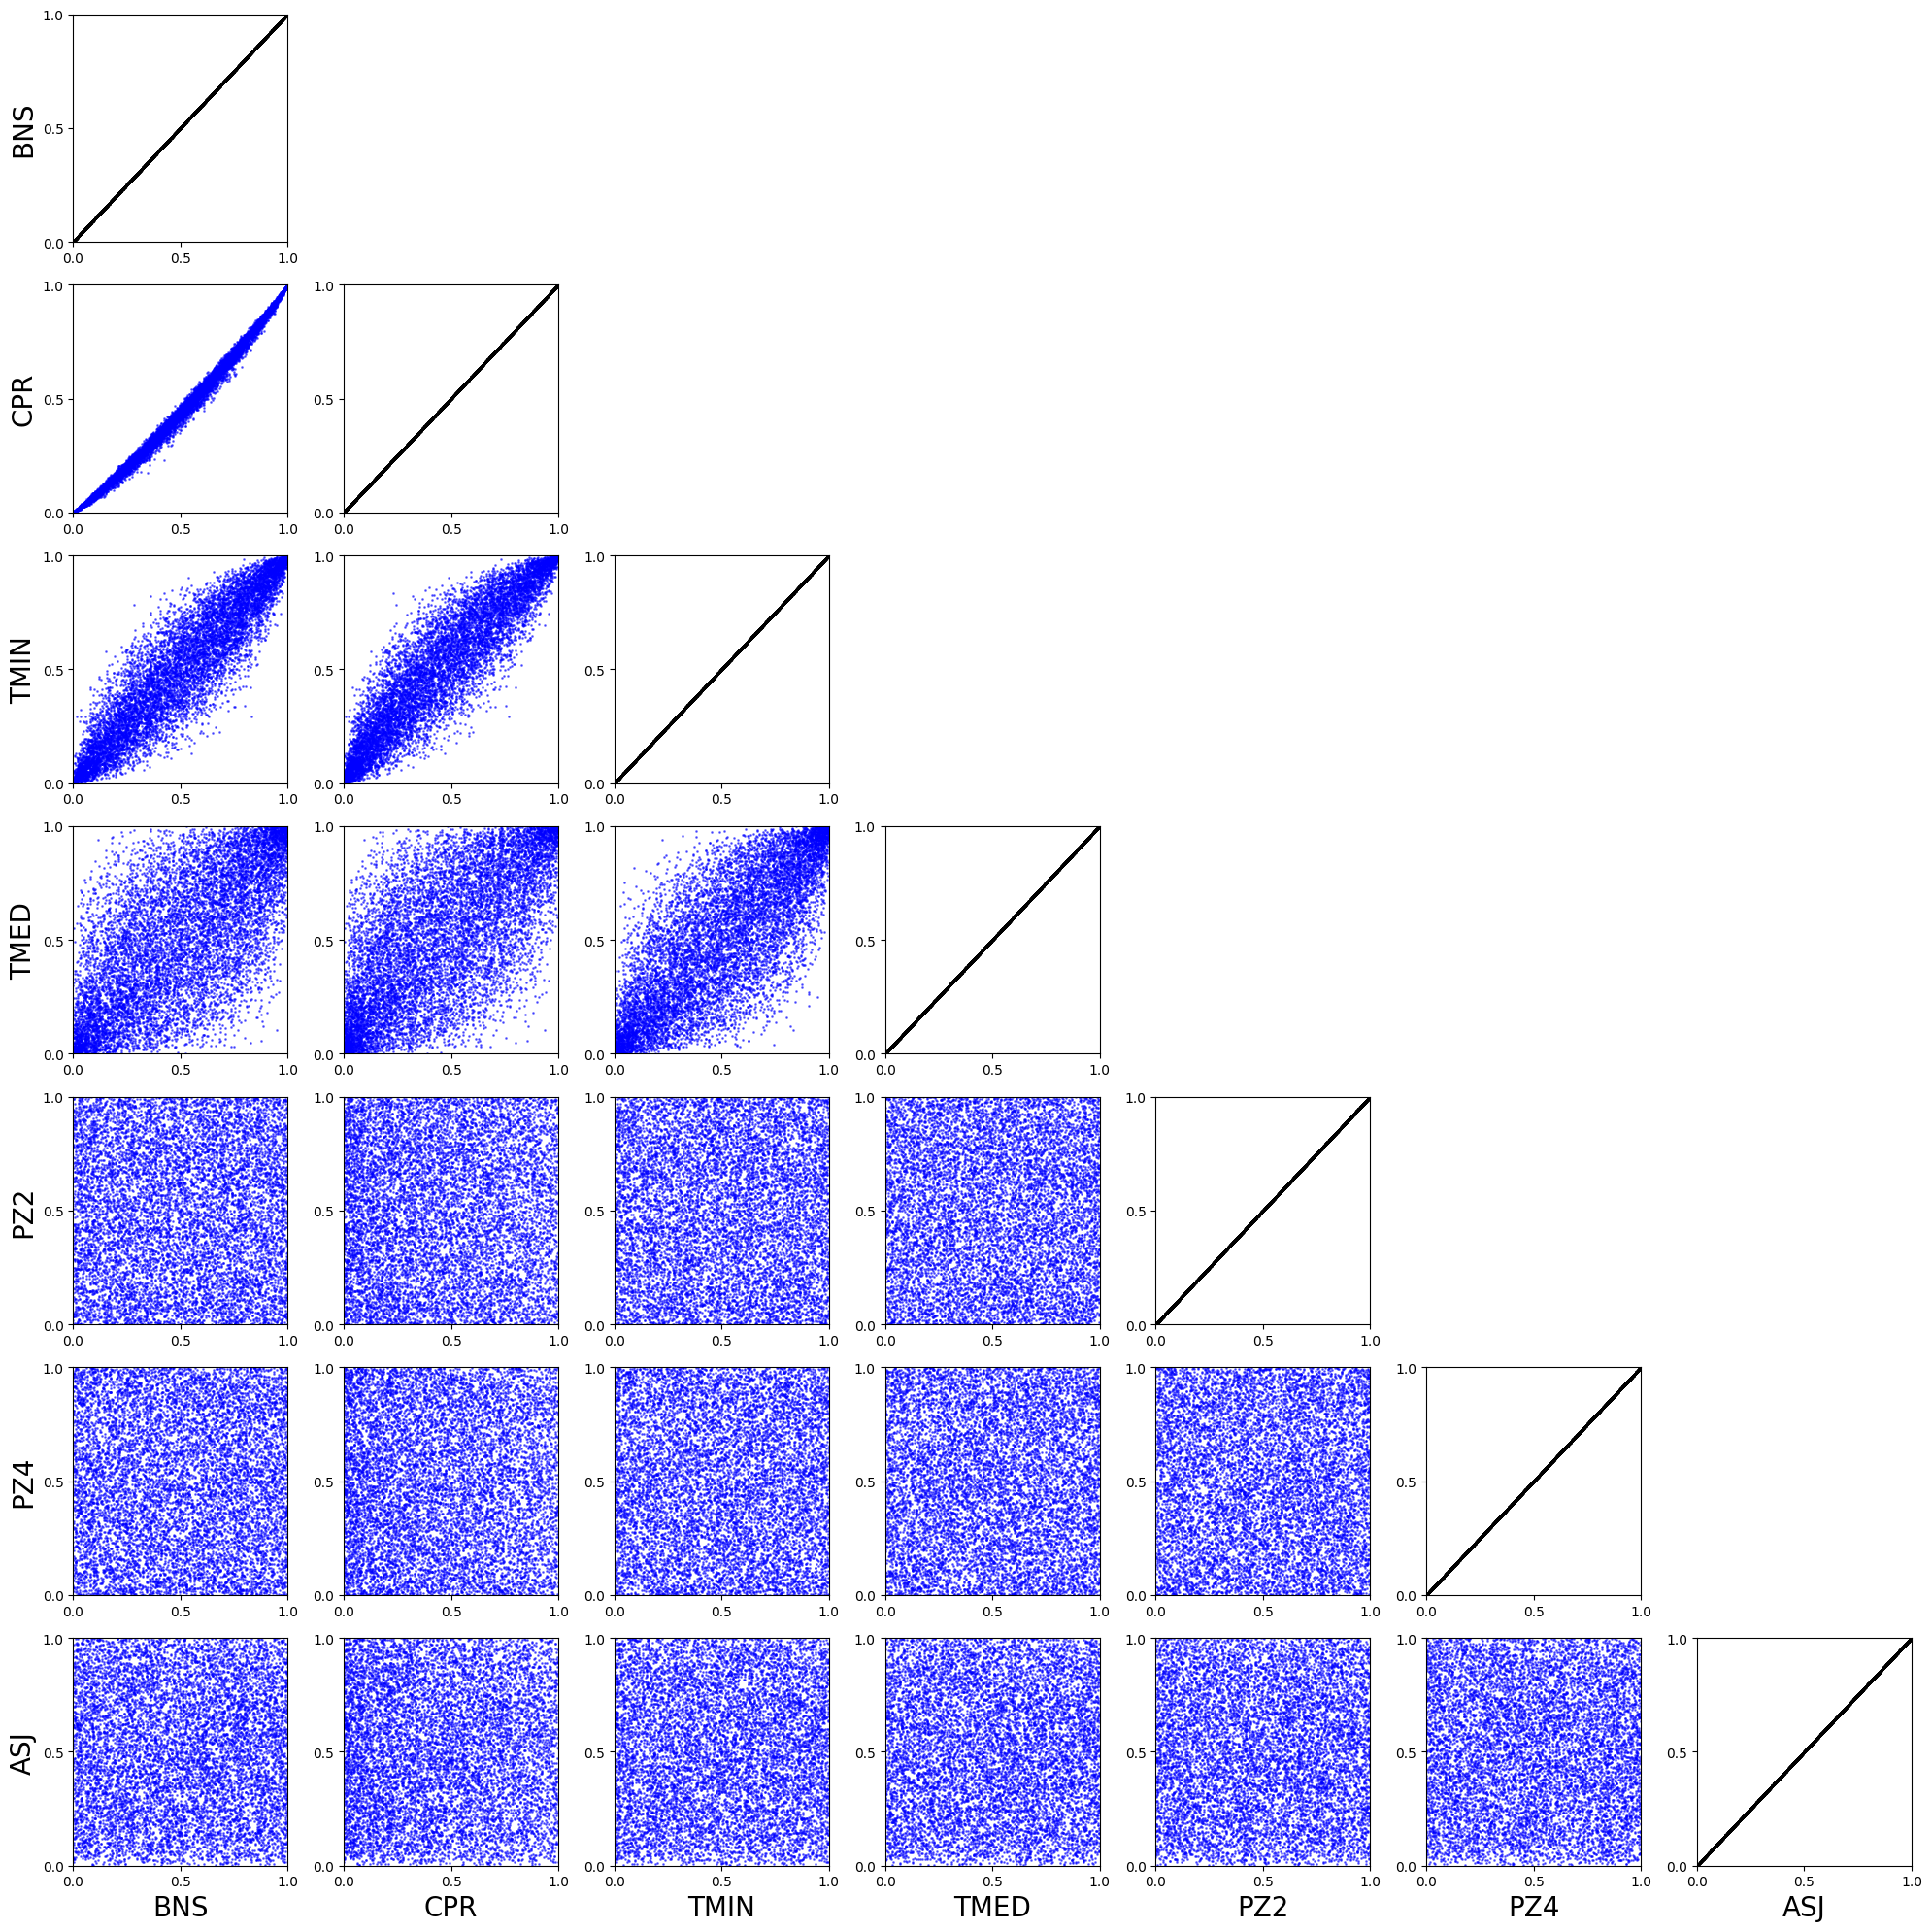

In [41]:
# Extract p-values for each test
test_names = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']
p_values_dict = {name: np.array(loaded_p_values['No']['No']['No'][name]) for name in test_names}

# Create 7x7 subplot grid
fig, axes = plt.subplots(7, 7, figsize=(20, 20))  # Adjust figure size

# Loop through grid positions
for i, test_y in enumerate(test_names):  # Y-axis in normal order
    for j, test_x in enumerate(test_names):  # X-axis in normal order
        ax = axes[i, j]

        if i > j:
            # Scatter plot for lower diagonal pairs
            ax.scatter(p_values_dict[test_x], p_values_dict[test_y], color='blue', alpha=0.5, s=1)  # Smaller points
        elif i == j:
            # Scatter plot on the diagonal (same test vs itself)
            ax.scatter(p_values_dict[test_x], p_values_dict[test_x], color='black', alpha=0.5, s=1)  # Smaller points
        else:
            # Hide upper diagonal plots
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis("off")

        # Set axis limits for all plots (0 to 1)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        # Set ticks for only 0 and 1 on both axes
        ax.set_xticks([0, 0.5, 1])
        ax.set_yticks([0, 0.5, 1])

        # Set labels only on the outermost plots
        if j == 0:
            ax.set_ylabel(test_y, fontsize=20)  # Larger font size for Y-axis labels
        if i == 6:  # Last row, set X labels
            ax.set_xlabel(test_x, fontsize=20)  # Larger font size for X-axis labels

# Adjust layout and ensure that labels are correctly spaced
plt.tight_layout()

# Display the plot
plt.show()

## Distribution of Tests compared to Normal distribution


===== Analyzing: BNS =====



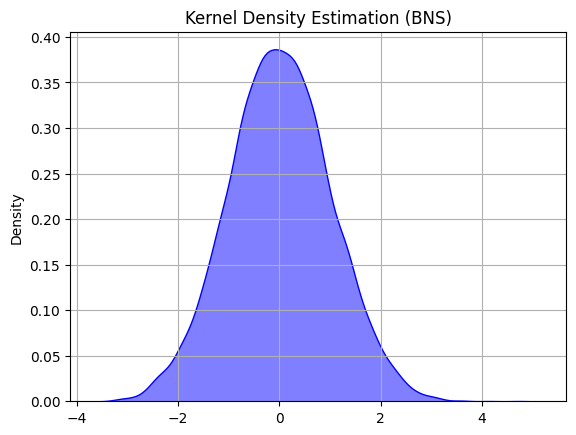

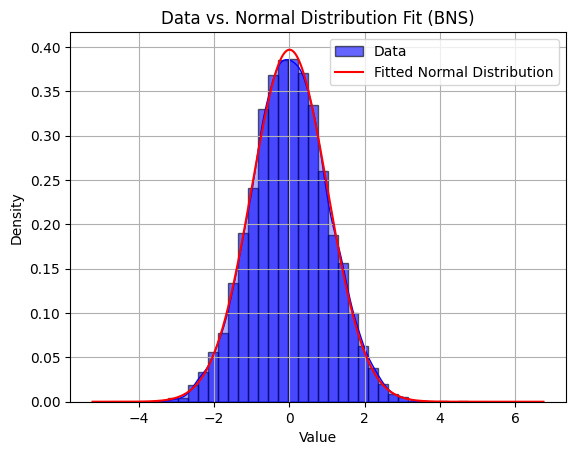

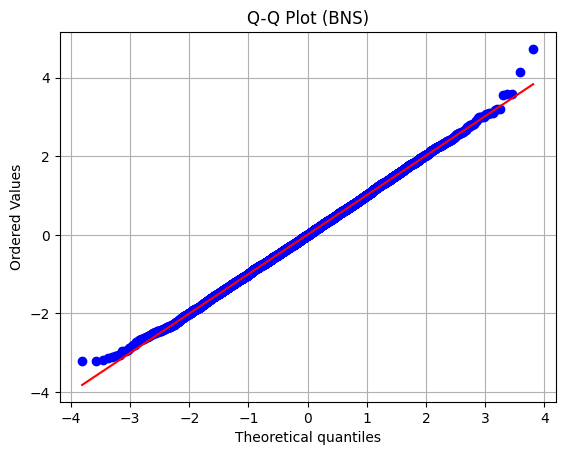

Skewness: 0.052
Kurtosis: -0.022
Shapiro-Wilk test statistic: 1.000, p-value: 0.036
Data is likely not normally distributed.
Anderson-Darling Statistic: 0.480
Data is likely normally distributed.
KS test statistic: 0.007, p-value: 0.683
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 4.647, p-value: 0.098
Data is likely normally distributed.

===== Analyzing: CPR =====



c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


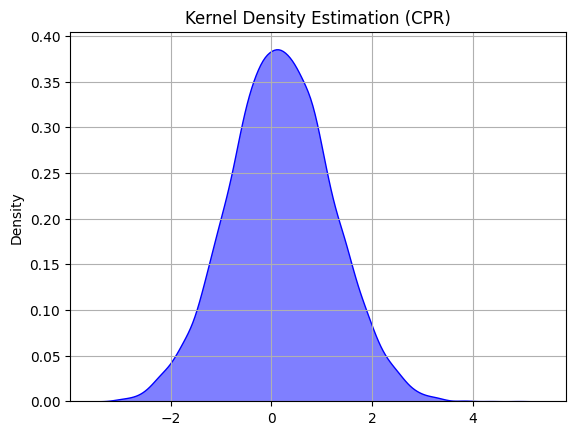

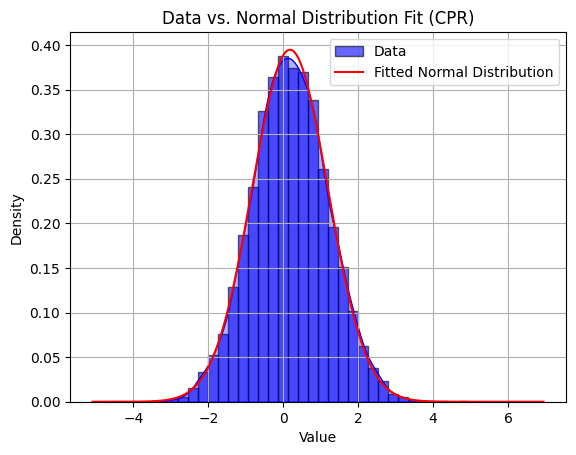

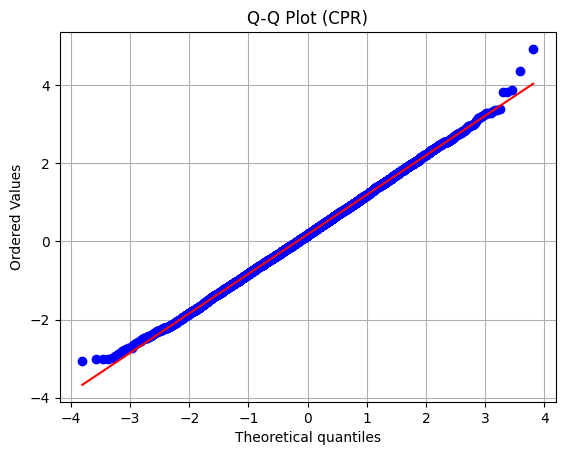

Skewness: 0.051
Kurtosis: -0.022
Shapiro-Wilk test statistic: 1.000, p-value: 0.044
Data is likely not normally distributed.
Anderson-Darling Statistic: 0.418
Data is likely normally distributed.
KS test statistic: 0.008, p-value: 0.552
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 4.464, p-value: 0.107
Data is likely normally distributed.

===== Analyzing: TMIN =====



c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


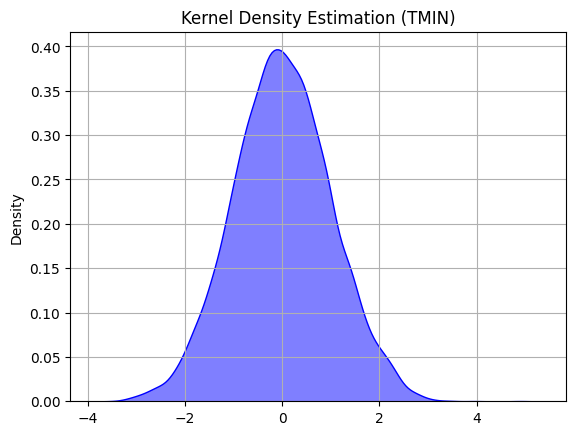

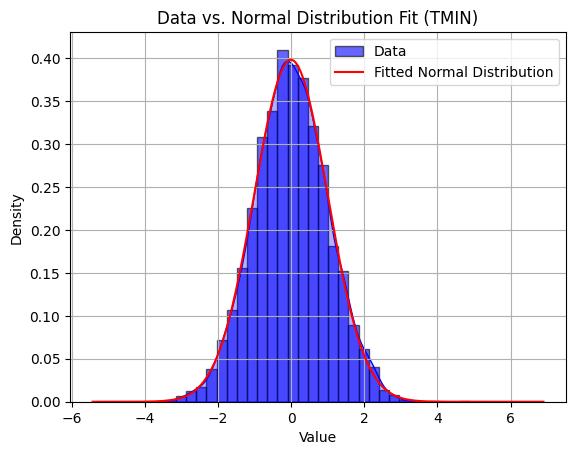

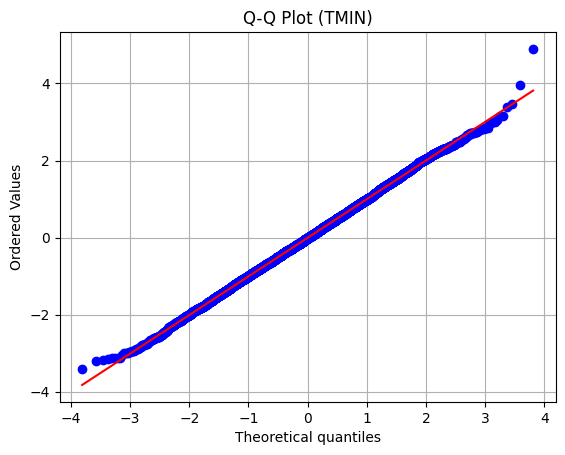

Skewness: 0.025
Kurtosis: -0.011
Shapiro-Wilk test statistic: 1.000, p-value: 0.049
Data is likely not normally distributed.
Anderson-Darling Statistic: 0.454
Data is likely normally distributed.
KS test statistic: 0.007, p-value: 0.784
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 1.116, p-value: 0.572
Data is likely normally distributed.

===== Analyzing: TMED =====



c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


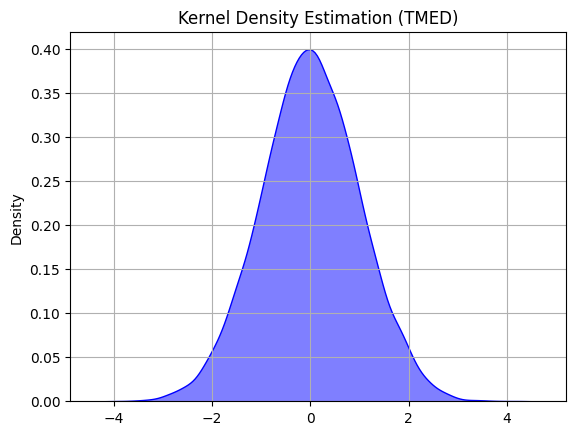

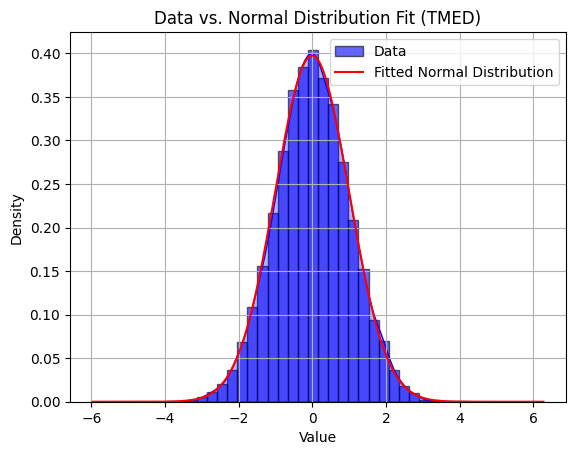

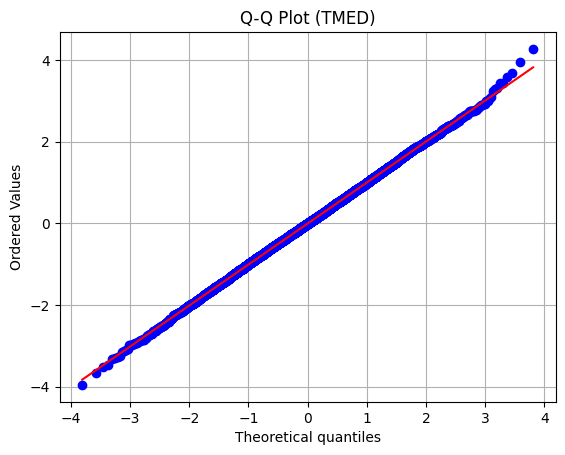

Skewness: -0.005
Kurtosis: 0.043
Shapiro-Wilk test statistic: 1.000, p-value: 0.945
Data is likely normally distributed.
Anderson-Darling Statistic: 0.243
Data is likely normally distributed.
KS test statistic: 0.005, p-value: 0.973
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 0.850, p-value: 0.654
Data is likely normally distributed.

===== Analyzing: PZ2 =====



c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


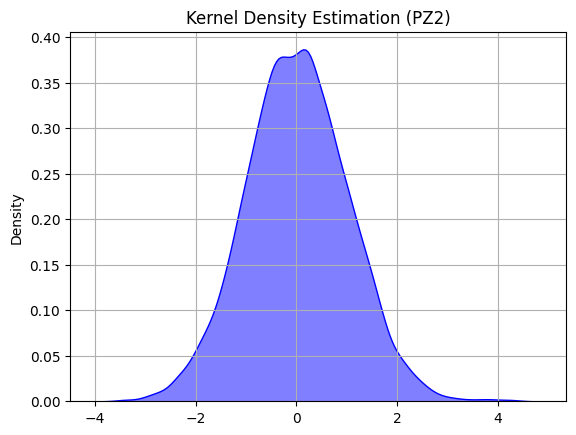

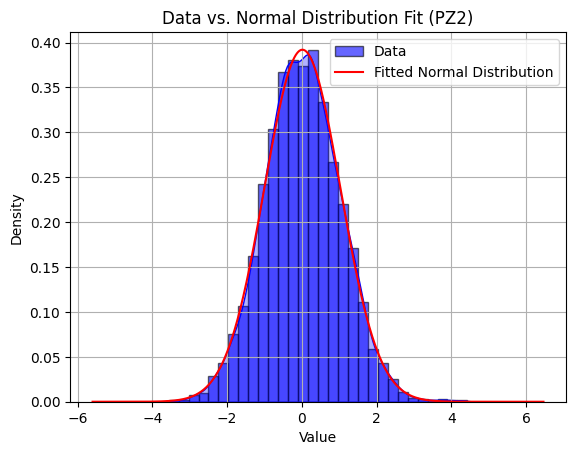

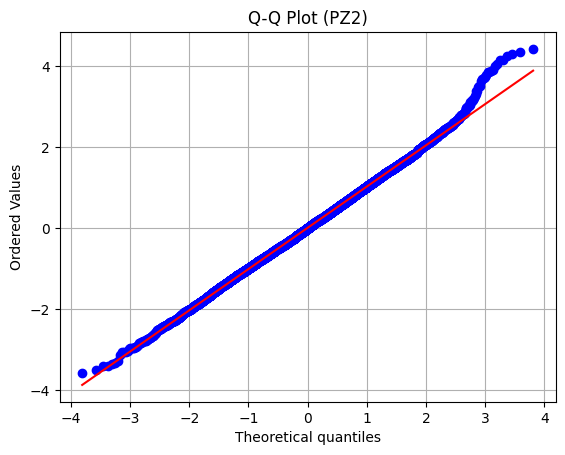

Skewness: 0.102
Kurtosis: 0.247
Shapiro-Wilk test statistic: 0.999, p-value: 0.000
Data is likely not normally distributed.
Anderson-Darling Statistic: 1.096
Data is likely not normally distributed.
KS test statistic: 0.010, p-value: 0.287
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 37.702, p-value: 0.000
Data is likely not normally distributed.

===== Analyzing: PZ4 =====



c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


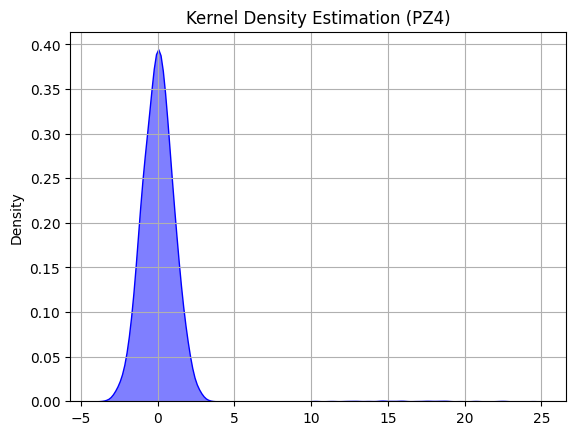

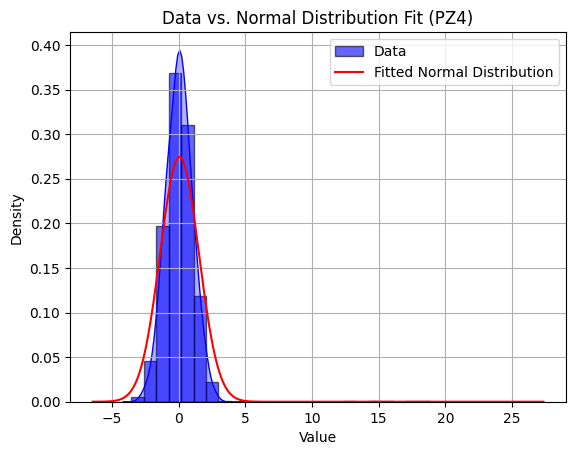

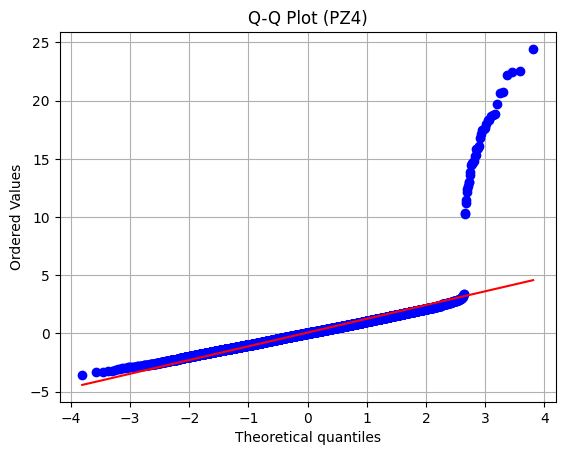

Skewness: 6.288
Kurtosis: 78.048
Shapiro-Wilk test statistic: 0.661, p-value: 0.000
Data is likely not normally distributed.
Anderson-Darling Statistic: 285.222
Data is likely not normally distributed.
KS test statistic: 0.098, p-value: 0.000
Data is likely not normally distributed.
D'Agostino-Pearson test statistic: 12076.525, p-value: 0.000
Data is likely not normally distributed.

===== Analyzing: ASJ =====



c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


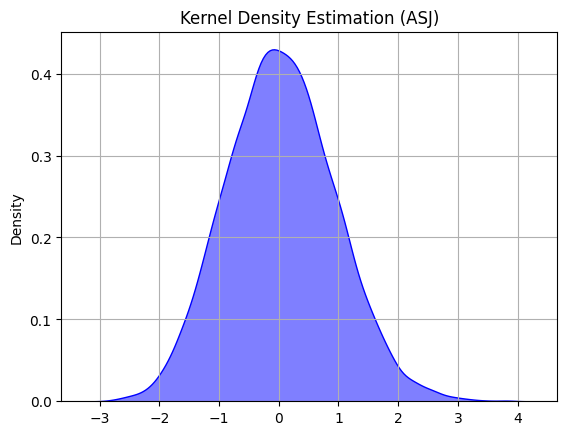

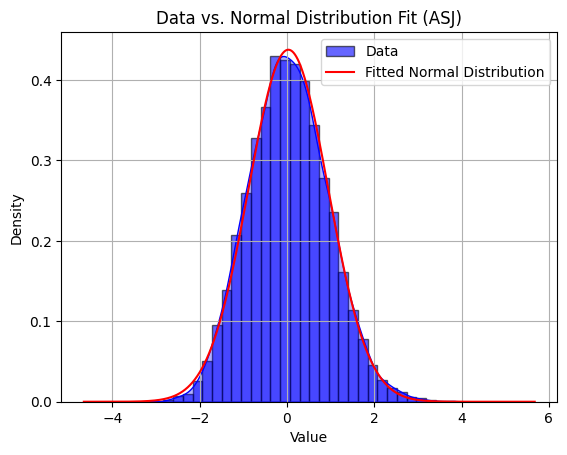

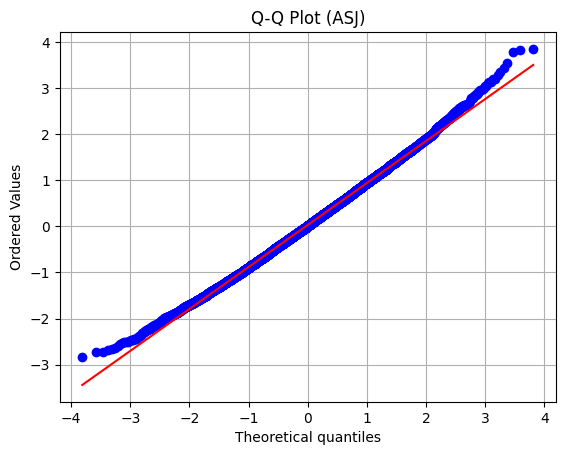

Skewness: 0.171
Kurtosis: 0.029
Shapiro-Wilk test statistic: 0.998, p-value: 0.000
Data is likely not normally distributed.
Anderson-Darling Statistic: 2.332
Data is likely not normally distributed.
KS test statistic: 0.011, p-value: 0.169
Data is likely normally distributed.
D'Agostino-Pearson test statistic: 48.576, p-value: 0.000
Data is likely not normally distributed.


c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [47]:
from scipy.stats import skew, kurtosis

# Ensure proper float formatting
pd.options.display.float_format = '{:.3f}'.format

# Define test names
test_names = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']

# Loop through each dataset
for name in test_names:
    data = np.array(loaded_combined_dataset['No']['No']['No'][name])  # Ensure NumPy array
    print(f"\n===== Analyzing: {name} =====\n")
    
    # KDE Plot
    sns.kdeplot(data, fill=True, color='blue', alpha=0.5)
    plt.title(f'Kernel Density Estimation ({name})')
    plt.grid(True)
    plt.show()

    # Compute mean and standard deviation
    mu, std = np.mean(data), np.std(data)

    # Define x range for normal distribution plot
    x = np.linspace(min(data) - 2*std, max(data) + 2*std, 5000)

    # Calculate the PDF of the normal distribution
    pdf = stats.norm.pdf(x, mu, std)

    # Plot Histogram and Normal Fit
    plt.hist(data, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black', label='Data')
    sns.kdeplot(data, color='blue', fill=True, alpha=0.3)
    plt.plot(x, pdf, 'r-', label='Fitted Normal Distribution')
    plt.legend()
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f'Data vs. Normal Distribution Fit ({name})')
    plt.grid(True)
    plt.show()

    # Q-Q Plot
    stats.probplot(data, dist='norm', plot=plt)
    plt.title(f"Q-Q Plot ({name})")
    plt.grid(True)
    plt.show()

    # Compute Skewness and Kurtosis
    print(f"Skewness: {skew(data):.3f}")
    print(f"Kurtosis: {kurtosis(data):.3f}")

    # Perform Normality Tests

    # Shapiro-Wilk Test
    stat, p_value = stats.shapiro(data)
    print(f"Shapiro-Wilk test statistic: {stat:.3f}, p-value: {p_value:.3f}")
    print("Data is likely normally distributed." if p_value > 0.05 else "Data is likely not normally distributed.")

    # Anderson-Darling Test
    result = stats.anderson(data, dist='norm')
    print(f"Anderson-Darling Statistic: {result.statistic:.3f}")
    if result.statistic < result.critical_values[2]:  # 5% significance level
        print("Data is likely normally distributed.")
    else:
        print("Data is likely not normally distributed.")

    # Kolmogorov-Smirnov Test
    stat, p_value = stats.kstest(data, 'norm', args=(mu, std))
    print(f"KS test statistic: {stat:.3f}, p-value: {p_value:.3f}")
    print("Data is likely normally distributed." if p_value > 0.05 else "Data is likely not normally distributed.")

    # D'Agostino and Pearson's Test
    stat, p_value = stats.normaltest(data)
    print(f"D'Agostino-Pearson test statistic: {stat:.3f}, p-value: {p_value:.3f}")
    print("Data is likely normally distributed." if p_value > 0.05 else "Data is likely not normally distributed.")


# Check for Multivariate Normality of Joint Tests

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Mardia's Test Results:
HZResults(hz=1.8061287903033976, pval=0.0, normal=False)


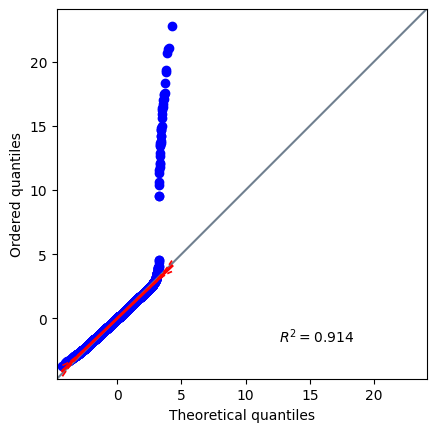

In [39]:
import pingouin as pg

# Select multiple variables from the dataset
selected_vars = ['BNS', 'CPR', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']

data = loaded_combined_dataset['No']['No']['No'][selected_vars]

# Drop missing values
data = data.dropna()

# Perform Mardia’s Test
mardia_results = pg.multivariate_normality(data, alpha=0.05)

# Print results
print("Mardia's Test Results:")
print(mardia_results)

ax = pg.qqplot(data, dist='norm')


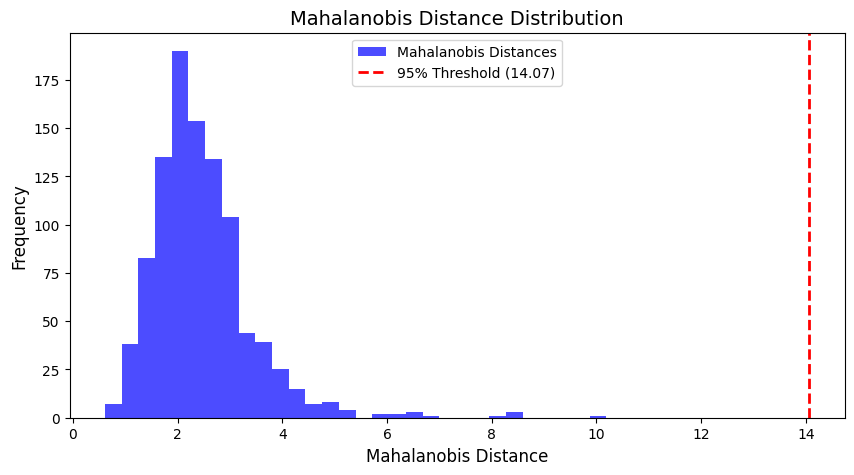

Potential Outliers based on Mahalanobis Distance:
 Empty DataFrame
Columns: [CPR, BNS, TMIN, TMED, PZ2, PZ4, ASJ]
Index: []


In [12]:
# Select multiple variables from the dataset
selected_vars = ['CPR', 'BNS', 'TMIN', 'TMED', 'PZ2', 'PZ4', 'ASJ']
data = loaded_combined_dataset['No']['No']['No'][selected_vars]

# Drop any NaN values to avoid issues
data = data.dropna()

# Convert to NumPy array for calculations
data_array = data.to_numpy()

# Compute the mean vector and covariance matrix
mean_vec = np.mean(data_array, axis=0)  # Mean of each column
cov_matrix = np.cov(data_array, rowvar=False)  # Covariance matrix

# Compute the inverse covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)  

# Compute Mahalanobis distance for each observation
diff = data_array - mean_vec  # Difference from mean
mahalanobis_distances = np.sqrt(np.sum(diff @ inv_cov_matrix * diff, axis=1))

# Compute the chi-squared critical value (95% confidence level)
df = len(selected_vars)  # Degrees of freedom = number of variables
chi_squared_threshold = stats.chi2.ppf(0.95, df)

# Plot the Mahalanobis distances
plt.figure(figsize=(10, 5))
plt.hist(mahalanobis_distances, bins=30, alpha=0.7, color='blue', label='Mahalanobis Distances')
plt.axvline(x=chi_squared_threshold, color='red', linestyle='dashed', linewidth=2, label=f'95% Threshold ({chi_squared_threshold:.2f})')

# Labels and title
plt.xlabel('Mahalanobis Distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Mahalanobis Distance Distribution', fontsize=14)
plt.legend()
plt.show()

# Identify potential outliers
outliers = data[mahalanobis_distances > chi_squared_threshold]
print("Potential Outliers based on Mahalanobis Distance:\n", outliers)


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check and clean the data
selected_vars = ['CPR', 'BNS', 'TMIN', 'TMED']


# Convert the selected columns to numeric, coercing errors to NaN
# Assuming that 'loaded_combined_dataset' is a DataFrame, apply the transformation to the selected columns
loaded_combined_dataset[selected_vars] = loaded_combined_dataset[selected_vars].apply(pd.to_numeric, errors='coerce')
loaded_combined_dataset[selected_vars]

# Replace infinite values with NaN
loaded_combined_dataset[selected_vars] = loaded_combined_dataset[selected_vars].replace([float('inf'), float('-inf')], float('nan'))


# Optionally, drop rows with NaN values in selected columns
loaded_combined_dataset = loaded_combined_dataset.dropna(subset=selected_vars)


# Create pairplot
sns.pairplot(loaded_combined_dataset, diag_kind="kde")

# Show the plot
plt.show()



TypeError: unhashable type: 'list'

In [14]:
import hyppo.independence as hi

# Prepare data
selected_vars = ['CPR', 'BNS', 'TMIN', 'TMED', 'PZ2', 'PZ4']
data = loaded_combined_dataset['No']['No']['No'][selected_vars]

# Example: Split data into three sets of variables
data1 = data[['CPR', 'BNS']]
data2 = data[['TMIN', 'TMED']]
data3 = data[['PZ2', 'PZ4']]

# Perform HSIC test pairwise between all combinations
hsic_test_1_2 = hi.HSIC()
stat_1_2, p_value_1_2 = hsic_test_1_2.test(data1.values, data2.values)

hsic_test_2_3 = hi.HSIC()
stat_2_3, p_value_2_3 = hsic_test_2_3.test(data2.values, data3.values)

hsic_test_1_3 = hi.HSIC()
stat_1_3, p_value_1_3 = hsic_test_1_3.test(data1.values, data3.values)

# Display results
print(f"HSIC Test between data1 and data2: p-value={p_value_1_2:.4f}")
print(f"HSIC Test between data2 and data3: p-value={p_value_2_3:.4f}")
print(f"HSIC Test between data1 and data3: p-value={p_value_1_3:.4f}")

# If all p-values are high, we may consider the variables to be independent.


ModuleNotFoundError: No module named 'past'

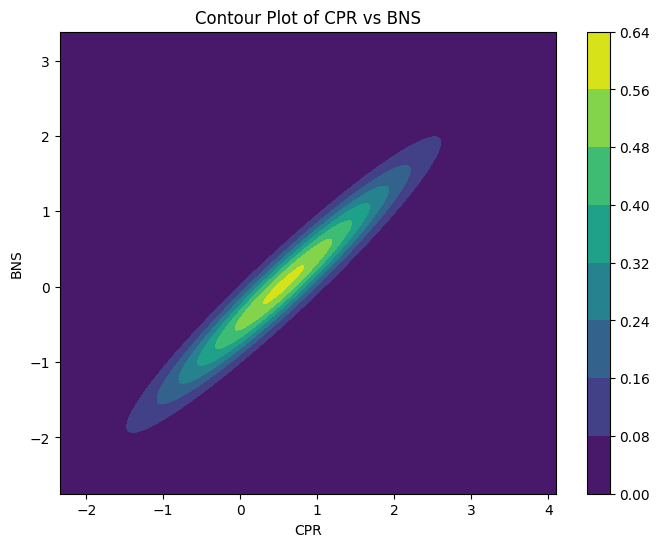

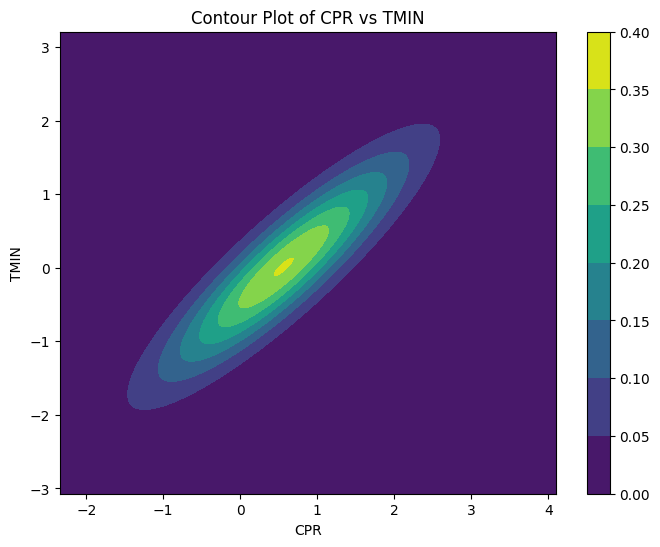

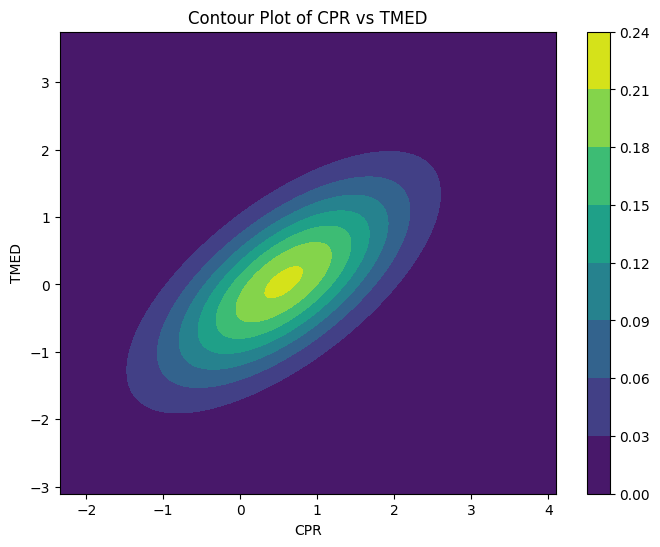

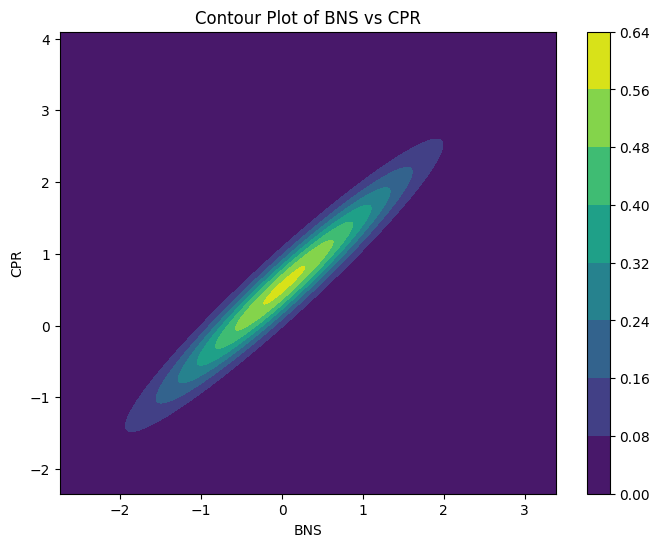

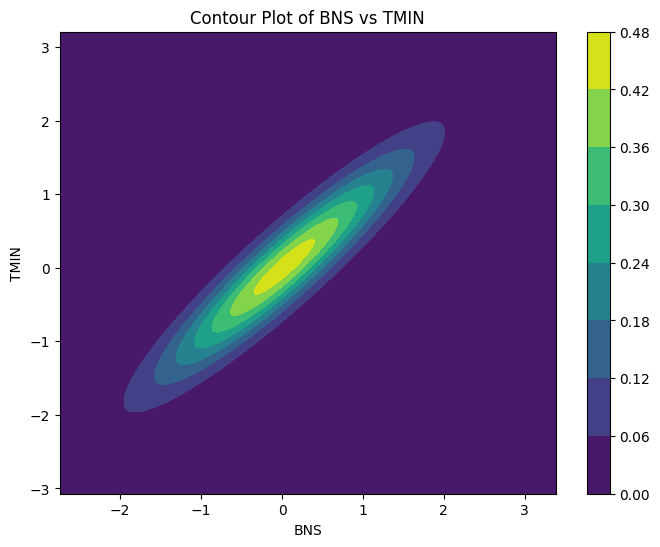

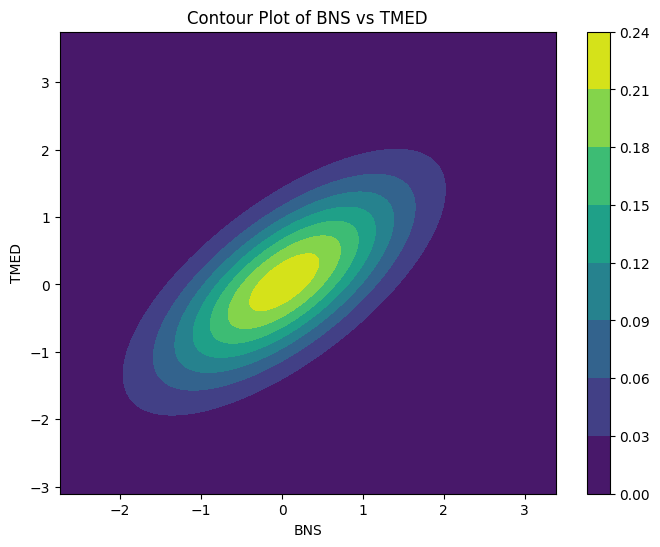

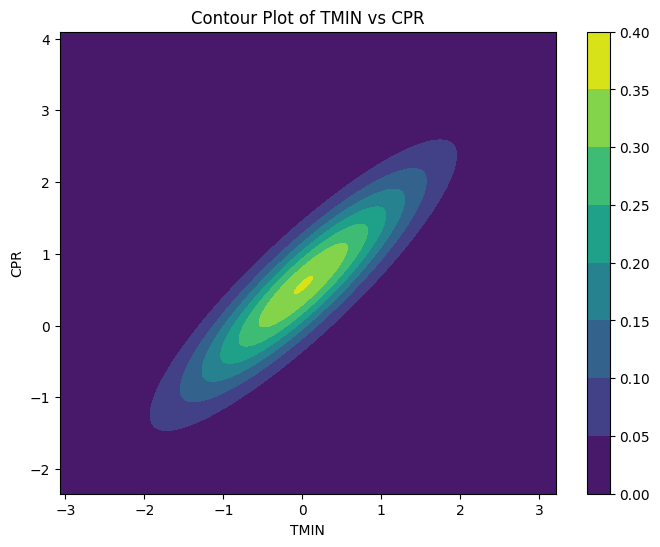

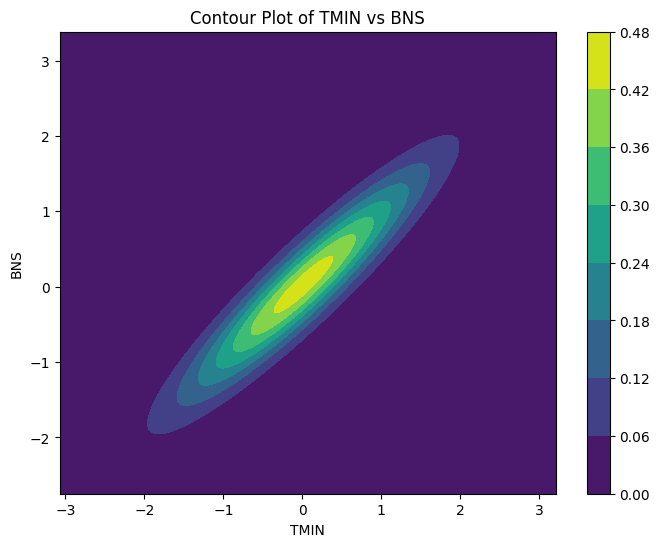

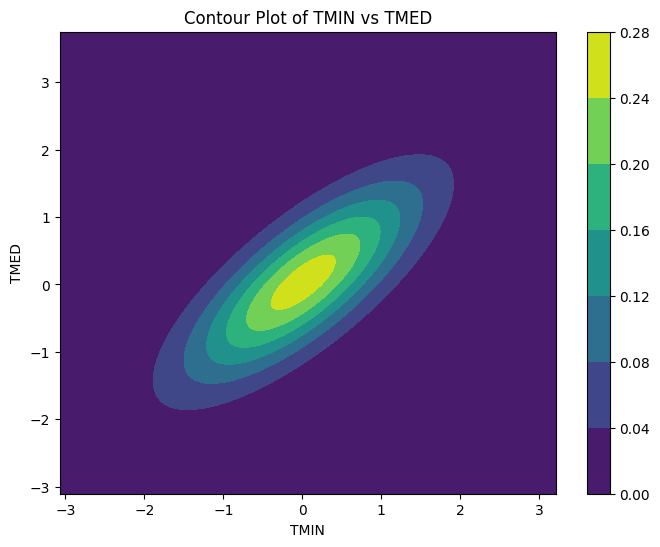

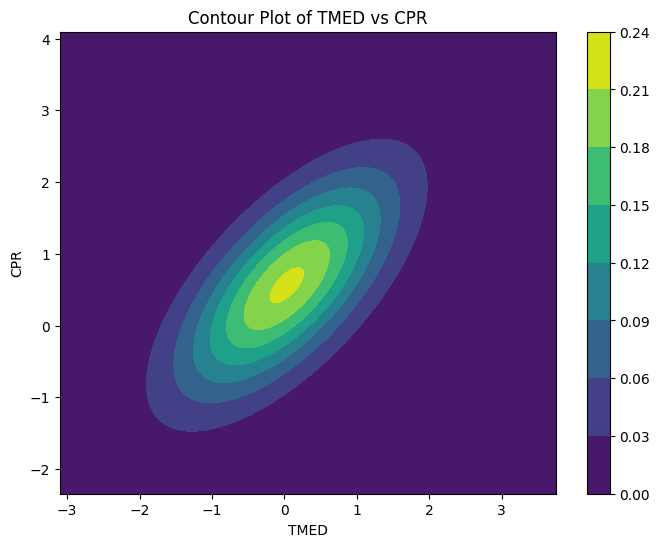

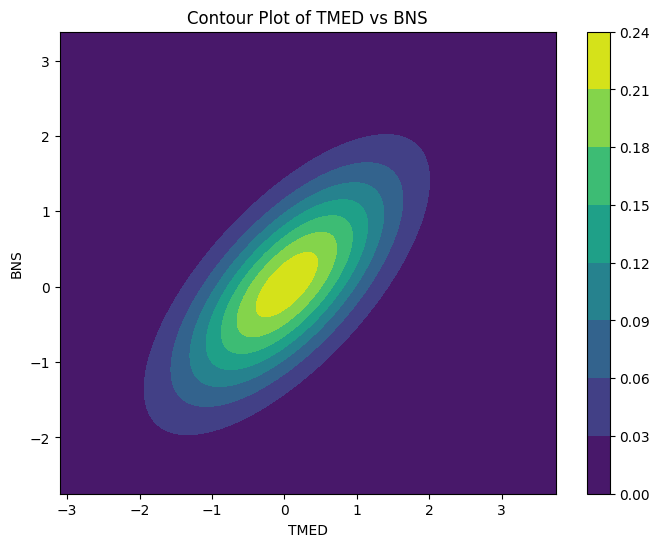

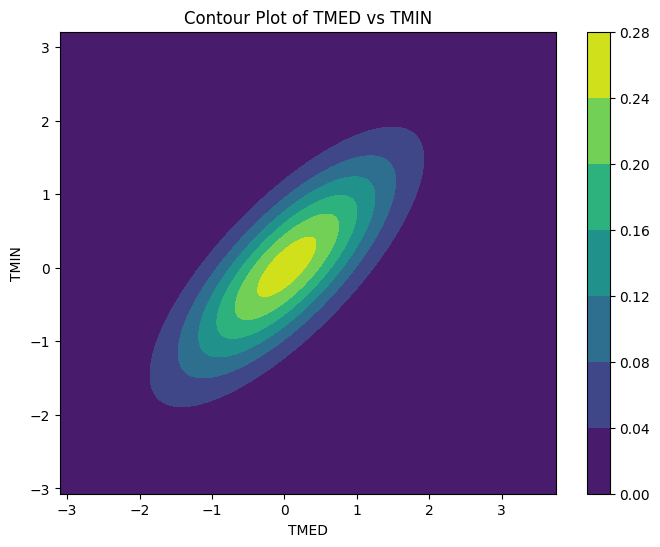

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Select multiple variables from the dataset
selected_vars = ['CPR', 'BNS', 'TMIN', 'TMED']
data = loaded_combined_dataset['No']['No']['No'][selected_vars]

# Drop missing values (if any)
data = data.dropna()

# Plot the contour plot for each pair of selected variables
for var_x in selected_vars:
    for var_y in selected_vars:
        if var_x != var_y:
            # Define the grid of points for the contour plot
            x, y = np.mgrid[data[var_x].min():data[var_x].max():0.01, 
                            data[var_y].min():data[var_y].max():0.01]
            pos = np.dstack((x, y))

            # Define the mean vector and covariance matrix
            mean = [data[var_x].mean(), data[var_y].mean()]
            cov = np.cov(data[var_x], data[var_y])

            # Create the multivariate normal distribution
            rv = multivariate_normal(mean, cov)

            # Create the figure for plotting
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111)

            # Plot the filled contour plot
            contour = ax.contourf(x, y, rv.pdf(pos), cmap='viridis')

            # Add color bar
            fig.colorbar(contour)

            # Set axis labels and title
            ax.set_xlabel(var_x)
            ax.set_ylabel(var_y)
            ax.set_title(f'Contour Plot of {var_x} vs {var_y}')

            # Show the plot
            plt.show()


P-values for 'LM': 0      0.333
1      0.128
2      0.217
3      0.161
4      0.115
        ... 
9995   0.008
9996   0.133
9997   0.390
9998   0.291
9999   0.283
Name: LM, Length: 10000, dtype: float64


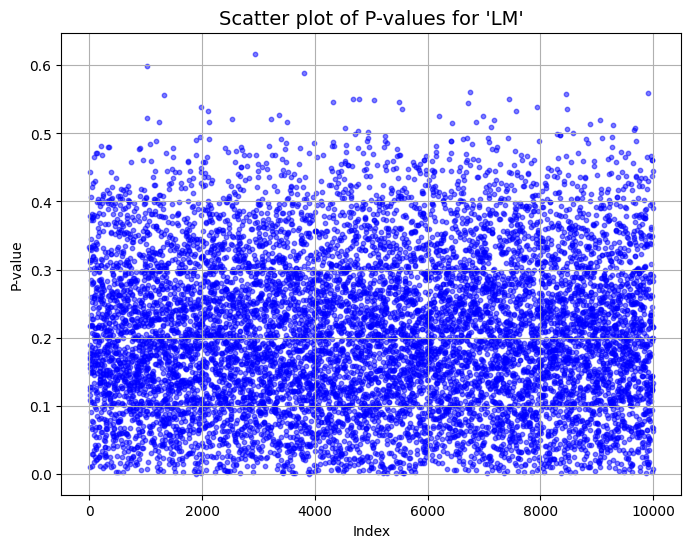

In [122]:
pd.options.display.float_format = '{:.3f}'.format
#print(p_values['1']['4']['No'])  # Now displays numbers with 3 decimal places
# Extract p-values for 'LM' test
lm_p_values = p_values['No']['No']['No']['LM']

# Print the p-values
print("P-values for 'LM':", lm_p_values)

# Scatter plot of the p-values
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(lm_p_values)), lm_p_values, color='blue', alpha=0.5, s=10)
plt.title("Scatter plot of P-values for 'LM'", fontsize=14)
plt.xlabel("Index")
plt.ylabel("P-value")
plt.grid(True)
plt.show()

## P-value scatterplots

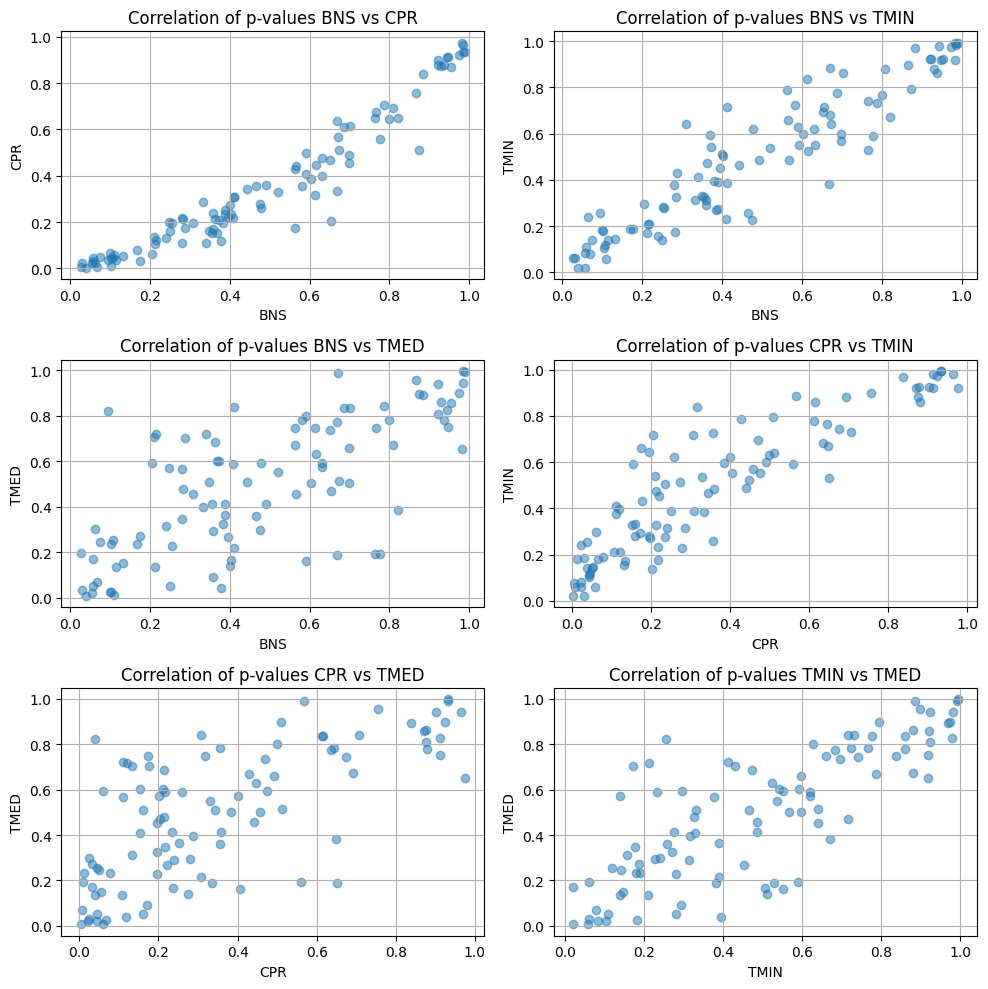

In [290]:
import matplotlib.pyplot as plt
import itertools

corr_df = p_values['1']['1']['No'].iloc[:, [0, 1, 2, 3]] 
# Get column names from DataFrame
column_names = corr_df.columns

# Generate all possible pairs of column indices
pairs = list(itertools.combinations(range(len(column_names)), 2))

# Determine the number of rows and columns for subplots
num_pairs = len(pairs)
num_cols = 2  # Number of columns for subplots
num_rows = (num_pairs + num_cols - 1) // num_cols  # Ceiling division

# Create scatterplots for each pair of variables
plt.figure(figsize=(10, 10))
for i, pair in enumerate(pairs):
    plt.subplot(num_rows, num_cols, i + 1)  # Adjust subplot layout based on num_rows and num_cols
    plt.scatter(corr_df.iloc[:, pair[0]], corr_df.iloc[:, pair[1]], alpha=0.5)
    plt.xlabel(column_names[pair[0]])
    plt.ylabel(column_names[pair[1]])
    plt.title(f'Correlation of p-values {column_names[pair[0]]} vs {column_names[pair[1]]}')
    plt.grid(True)

plt.tight_layout()
#plt.savefig('scatter_corr_5min_H0_New_Fisher.pdf')
plt.show()

<AxesSubplot:>

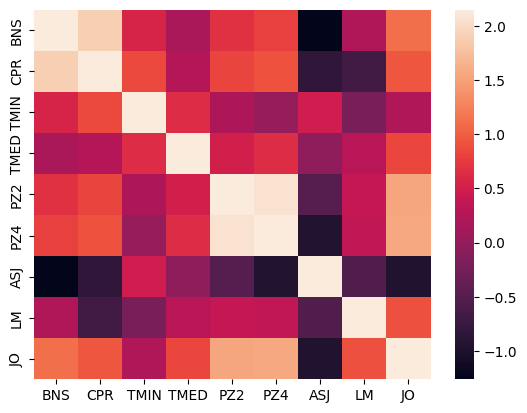

In [275]:
import seaborn as sns
sns.heatmap(covariance_matrices['1']['4']['No'])

In [92]:
import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF

def TransformData(data_vector):
    """
    Transforms a data vector using an empirical cumulative distribution function (ECDF).
    
    Parameters:
    - data_vector: list or array, raw data with no missing values.
    
    Returns:
    - np.array: Transformed data vector.
    """
    m = np.mean(data_vector)
    sd = np.std(data_vector)
    s = [(d - m) / sd for d in data_vector]
    W = lambda x: -2 * np.log(ECDF(s)(x))
    return np.array([W(x) for x in s])

def CalculateCovariances(data_matrix):
    """
    Computes the covariance matrix of pairwise transformed raw data vectors.

    Parameters:
    - data_matrix: pandas.DataFrame or numpy.array (m x n), where m is the number of variables (rows)
                   and n is the number of samples (columns).
                   Each row represents a variable, and each column represents a sample.
    
    Returns:
    - numpy.array (m x m): Covariance matrix of transformed data vectors.
    """
    # Ensure input is a NumPy array (handle DataFrame case)
    if isinstance(data_matrix, pd.DataFrame):
        data_matrix = data_matrix.to_numpy()  # Convert DataFrame to NumPy array
    
    # Check if the matrix is empty or contains NaN values
    if data_matrix.size == 0:
        raise ValueError("Input data matrix is empty.")
    if np.isnan(data_matrix).any():
        raise ValueError("Input data matrix contains missing values. Please handle them before proceeding.")

    # Apply TransformData to each row (variable)
    transformed_data_matrix = np.array([TransformData(row) for row in data_matrix])

    # Compute and return the covariance matrix
    covar_matrix = np.cov(transformed_data_matrix, rowvar=True)

    return covar_matrix


In [70]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import chi2, norm, gumbel_r 

def TransformData(data_vector):
    """
    Transforms a data vector using an empirical cumulative distribution function (ECDF).
    
    Parameters:
    - data_vector: list or array, raw data with no missing values.
    
    Returns:
    - np.array: Transformed data vector.
    """
    m = np.mean(data_vector)
    sd = np.std(data_vector)
    s = [(d - m) / sd for d in data_vector]
    
    ecdf = ECDF(s)
    W = lambda x: -2 * np.log(max(ecdf(x), 1e-10))  # Avoid log(0)
    #W = lambda x: -2 * np.log(ECDF(s)(x))
    return np.array([W(x) for x in s])

def CalculateCovariances(data_matrix):
    """
    Computes the covariance matrix of pairwise transformed raw data vectors.

    Parameters:
    - data_matrix: pandas.DataFrame or numpy.array (m x n), where m is the number of variables (rows)
                   and n is the number of samples (columns).
    
    Returns:
    - numpy.array (m x m): Covariance matrix of transformed data vectors.
    """
    if isinstance(data_matrix, pd.DataFrame):
        data_matrix = data_matrix.to_numpy()
    
    transformed_data_matrix = np.array([TransformData(row) for row in data_matrix])
    return np.cov(transformed_data_matrix, rowvar=True)

def calculate_ccdf_upper(element):
        return 1 - norm.cdf(element)

def calculate_ccdf_lower(element):
        return norm.cdf(element)

def calculate_ccdf_twoside(element):
        return 2 * (1 - norm.cdf(np.abs(element)))

def calculate_ccdf_gumbel(element):
        mu = 0  # Location parameter
        beta = 1  # Scale parameter
        return 1 - gumbel_r.cdf(element, loc=mu, scale=beta)

def CombinePValues(covar_matrix, p_values, extra_info = False):
    """
    Combines multiple p-values using Brown's method, which accounts for dependencies.

    Parameters:
    - covar_matrix: numpy.array (m x m), covariance matrix of transformed statistics.
    - p_values: list or array (m,), p-values to combine.
    - extra_info: bool, whether to return additional statistical information.

    Returns:
    - float: Combined p-value from Brown's method.
    - (optional) tuple: (p_brown, p_fisher, c, df_brown)
    """
    m = int(covar_matrix.shape[0])
    df_fisher = 2.0*m
    Expected = 2.0*m
    
    # Compute sum of off-diagonal elements
    #cov_sum = np.sum(np.triu(covar_matrix, 1))
    cov_sum = 0
    for i in range(m):
        for j in range(i+1, m):
            cov_sum += covar_matrix[i, j]
    
    # Compute variance and scaling factor
    Var = 4.0*m+2*cov_sum
    c = Var/(2.0*Expected)
    df_brown = 2.0*Expected**2/Var
    
    # Ensure df_brown does not exceed Fisher's df
    if df_brown > df_fisher:
        df_brown = df_fisher
        c = 1.0
    
    # Compute test statistic
    #x = 2.0*sum([-np.log(p) for p in p_values])
    x = 2.0 * np.sum(-np.log(np.clip(p_values, 1e-16, 1)))
    
    
    # Compute Brown’s and Fisher’s p-values
    p_brown = 1 - chi2.cdf(x / c, df_brown)
    p_fisher = 1 - chi2.cdf(x, df_fisher)
    
    if extra_info:
        return p_brown, p_fisher, c, df_brown
    else:
        return p_brown
    
def simulate_test_statistics(n, frequency, noise_categories, vol_jump_category, price_jump_category):
    """
    Simulates test statistics for combinations of volatility jumps, price jumps, and noise categories.
    Computes transformed data and covariance matrices.

    Returns:
    - dict: Nested dictionary with original test statistics.
    - dict: Nested dictionary with covariance matrices of transformed data.
    - dict: Nested dictionary with p-values.
    """
    combined_dataset = {}
    covariance_matrices = {}
    p_values = {}
    p_new = {}

    for vol_jump in vol_jump_category:
        if vol_jump not in combined_dataset:
            combined_dataset[vol_jump] = {}
            covariance_matrices[vol_jump] = {}
            p_values[vol_jump] = {}
            p_new[vol_jump] = {}

        for price_jump in price_jump_category:
            if price_jump not in combined_dataset[vol_jump]:
                combined_dataset[vol_jump][price_jump] = {}
                covariance_matrices[vol_jump][price_jump] = {}
                p_values[vol_jump][price_jump] = {}
                p_new[vol_jump][price_jump] = {}

            for noise in noise_categories:

                test_results = {
                    'BNS': [], 'CPR': [], 'TMIN': [], 'TMED': [], 
                    'PZ2': [], 'PZ4': [], 'ASJ': [], 'LM': [], 'JO': []
                }
                
                p_brown = { 'Brown': []}

                for _ in range(n):
                    simulator = DGP(mu=0, kappa=5, rho=-0.5, theta=0.16, sigma_v=0.5, sec=frequency,
                                    price_jump=price_jump, volatility_jump=vol_jump, noise=noise)
                    r = simulator.generate_data()

                    test_results['BNS'].append(BNS(r))
                    test_results['CPR'].append(CPR(r, 10, 3))
                    test_results['TMIN'].append(TMIN(r))
                    test_results['TMED'].append(TMED(r))
                    test_results['PZ2'].append(PZ2(r, 0.05))
                    test_results['PZ4'].append(PZ4(r, 0.05))
                    test_results['ASJ'].append(ASJ(r, 10))
                    test_results['LM'].append(LM(r, 10))
                    test_results['JO'].append(JO(r))

                df = pd.DataFrame(test_results)
                combined_dataset[vol_jump][price_jump][noise] = df
                
                # Compute covariance on transposed transformed data
                covariance_matrices[vol_jump][price_jump][noise] = CalculateCovariances(df.T)

                # Apply p-value transformations
                df_transformed = pd.DataFrame()
                df_transformed = df.iloc[:, :6].applymap(calculate_ccdf_upper)  # Upper-sided tests for first 6 columns
                df_transformed['ASJ'] = df.iloc[:, 6].apply(calculate_ccdf_lower)  # Lower-sided test for 'ASJ'
                df_transformed['LM'] = df.iloc[:, 7].apply(calculate_ccdf_gumbel)  # Gumbel distribution for 'LM'
                df_transformed['JO'] = df.iloc[:, 8].apply(calculate_ccdf_twoside)  # Two-sided test for 'JO'

                # Store the transformed DataFrame in the nested structure
                p_values[vol_jump][price_jump][noise] = df_transformed
            
                # Compute new p-values
                for i in range(n):
                    p_val = p_values[vol_jump][price_jump][noise].iloc[i]
                    cov_matrix = covariance_matrices[vol_jump][price_jump][noise]
    
                    p_brown['Brown'].append(CombinePValues(cov_matrix, p_val))

                df_brown = pd.DataFrame(p_brown)
                p_new[vol_jump][price_jump][noise] = df_brown
                # Append "Brown" column from p_new to p_values
                p_values[vol_jump][price_jump][noise]['Brown'] = p_new[vol_jump][price_jump][noise]['Brown']

    return combined_dataset, p_values, covariance_matrices


# Combining p-values

In [79]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF #empirical cumulative distribution function
from scipy.special import chdtrc as chi2_cdf
from scipy.stats import pearsonr

#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array
#       A vector of m P-values to combine. May be a list or of type numpy.array.
#Output: A combined P-value using the Empirical Brown's Method (EBM).
#        If extra_info == True: also returns the p-value from Fisher's method, the scale factor c, and the new degrees of freedom from Brown's Method
def EmpiricalBrownsMethod(data_matrix, p_values, extra_info = False):
    covar_matrix = CalculateCovariances(data_matrix)
    return CombinePValues(covar_matrix, p_values, extra_info)


#Input: raw data vector (of one variable) with no missing samples. May be a list or an array.
#Output Transforemd data vector w.
def TransformData(data_vector):
    m = np.mean(data_vector)
    sd = np.std(data_vector)
    s = [(d-m)/sd for d in data_vector]
    W = lambda x: -2*np.log(ECDF(s)(x))
    return np.array([W(x) for x in s])

#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array.
#       Note: Method does not deal with missing values within the data.
#Output: An m x m matrix of pairwise covariances between transformed raw data vectors
def CalculateCovariances(data_matrix):
    transformed_data_matrix = np.array([TransformData(f) for f in data_matrix])
    covar_matrix = np.cov(transformed_data_matrix)

    return covar_matrix
    
#Input: A m x m numpy array of covariances between transformed data vectors and a vector of m p-values to combine.
#Output: A combined P-value. 
#        If extra_info == True: also returns the p-value from Fisher's method, the scale factor c, and the new degrees of freedom from Brown's Method
def CombinePValues(covar_matrix, p_values, extra_info = False):
    m = int(covar_matrix.shape[0])
    #print "m", m
    df_fisher = 2.0*m
    Expected = 2.0*m
    cov_sum = 0
    for i in range(m):
        for j in range(i+1, m):
            cov_sum += covar_matrix[i, j]
    
    #print "cov sum", cov_sum
    Var = 4.0*m+2*cov_sum
    c = Var/(2.0*Expected)
    df_brown = 2.0*Expected**2/Var
    if df_brown > df_fisher:
        df_brown = df_fisher
        c = 1.0

    x = 2.0*sum([-np.log(p) for p in p_values])
    #print "x", x
    p_brown = chi2_cdf(df_brown, 1.0*x/c)
    p_fisher = chi2_cdf(df_fisher, 1.0*x)
    
    if extra_info:
        return p_brown, p_fisher, c, df_brown
    else:
        return p_brown

#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array
#       A vector of m P-values to combine. May be a list or of type numpy.array.
#Output: A combined P-value using Kost's Method.
#        If extra_info == True: also returns the p-value from Fisher's method, the scale factor c, and the new degrees of freedom from Brown's Method
def KostsMethod(data_matrix, p_values, extra_info = False):
    covar_matrix = CalculateKostCovariance(data_matrix)
    return CombinePValues(covar_matrix, p_values, extra_info = extra_info)
    
#Input correlation between two n x n data vectors.
#Output: Kost's approximation of the covariance between the -log cumulative distributions. This is calculated with a cubic polynomial fit.
def KostPolyFit(cor):
    a1, a2, a3 = 3.263, .710, .027 #Kost cubic coeficients
    return a1*cor+a2*cor**2+a3*cor**3
    
#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array.
#       Note: Method does not deal with missing values within the data.
#Output: An m x m matrix of pairwise covariances between the data vectors calculated using Kost's polynomial fit and numpy's pearson correlation function.
def CalculateKostCovariance(data_matrix):
    m = data_matrix.shape[0]
    covar_matrix = np.zeros((m, m))
    for i in range(m):
        for j in range(i+1, m):
            cor, p_val = pearsonr(data_matrix[i, :], data_matrix[j, :])
            covar = KostPolyFit(cor)
            covar_matrix[i, j] = covar
            covar_matrix[j, i] = covar
    return covar_matrix

In [84]:
# Initialize transformed_results dictionary
transformed_results = {}

# Iterate over the nested structure
for vol_jump, price_dict in combined_dataset.items():
    transformed_results[vol_jump] = {}
    
    for price_jump, noise_dict in price_dict.items():
        transformed_results[vol_jump][price_jump] = {}
        
        for noise, df in noise_dict.items():
            # Extract 'BNS' column and apply TransformData
            if 'BNS' in df:
                transformed_results[vol_jump][price_jump][noise] = {
                    'BNS': TransformData(df['BNS'])
                }
transformed_results

{'1': {'1': {'No': {'BNS': array([ 3.21887582,  1.02165125,  4.60517019,  1.38629436,  2.40794561,
            0.4462871 ,  0.21072103,  1.83258146, -0.        ,  0.71334989])}},
  '2': {'No': {'BNS': array([ 0.21072103,  4.60517019,  1.38629436,  0.71334989, -0.        ,
            1.02165125,  0.4462871 ,  3.21887582,  1.83258146,  2.40794561])}},
  '3': {'No': {'BNS': array([ 1.02165125, -0.        ,  0.21072103,  0.4462871 ,  2.40794561,
            1.83258146,  1.38629436,  0.71334989,  4.60517019,  3.21887582])}},
  '4': {'No': {'BNS': array([ 0.4462871 ,  0.71334989,  3.21887582,  4.60517019, -0.        ,
            1.02165125,  1.38629436,  2.40794561,  1.83258146,  0.21072103])}},
  '5': {'No': {'BNS': array([ 1.83258146,  3.21887582,  0.4462871 ,  1.02165125,  0.71334989,
           -0.        ,  0.21072103,  4.60517019,  1.38629436,  2.40794561])}},
  '6': {'No': {'BNS': array([ 1.38629436, -0.        ,  0.4462871 ,  1.02165125,  2.40794561,
            3.21887582,  0.2107

# P-values for CPR, PZ2, LM, JO

In [43]:

# Create an empty list to store transformed DataFrames
dfs_p2 = []

for i in range(100):
    # Create a new DataFrame by selecting specific columns
    df_temp = dfs_p[i].iloc[:, [1, 4, 7, 8]]
    dfs_p2.append(df_temp)
    
dfs_p2[1]


,CPR,PZ2,LM,JO
0,0.001066,0.380666,0.654331,0.000728


# Fisher Method all tests combined

In [122]:
from scipy.stats import chi2

def Combine_All_PValues(p_values):
    m = len(combined_p_values[0].columns[0:9])
    df_fisher = 2 * m
    x = -2 * sum([np.log(max(p, 1e-10)) for p in p_values])
    p_fisher = 1 - chi2.cdf(x, df_fisher)
    
    return p_fisher
    
results_fisher = []

# Iterate over each pair of DataFrame
for df_p len(combined_p_values)
    for df_p in p_table:
    # Initialize combined results for each pair of DataFrames
    p_fisher_list = []
    
    # Iterate over each row in the DataFrame
    for idx, row_p in df_p.iterrows():
        p_values = row_p.tolist()
        
        # Call CombinePValues for the current row
        p_fisher = Combine_All_PValues(p_values)
        
        # Append the results to the respective list
        p_fisher_list.append(p_fisher)
    
    # Append the combined results for the current pair of DataFrame and NumPy array to the overall results list
    results_fisher.append(p_fisher_list)

AttributeError: 'list' object has no attribute 'iloc'

## Add to p-value table

In [177]:
# Create DataFrame from results
results_df = pd.DataFrame({'p_fisher': results_fisher})

for i in range(len(dfs_p)):
    for j in range(1):
        column_name = 'Fisher_test' 
        dfs_p[i][column_name] = results_df.iloc[i, j]
dfs_p[3]

,BNS,CPR,TMIN,TMED,PZ2,PZ4,ASJ,LM,JO,Fisher_test
0,0.655960,0.098344,0.475500,0.488809,0.962704,0.895792,0.958939,0.709461,0.199564,0.809654
1,0.403879,0.147737,0.482622,0.805637,0.629635,0.095712,0.999992,0.793943,0.311672,0.596849
2,0.683532,0.001571,0.711047,0.534245,0.553290,0.906460,0.766521,0.481796,0.809163,0.367284
3,0.647453,0.260816,0.624030,0.654286,0.679987,0.689302,0.424764,0.262553,0.357853,0.773042
4,0.148613,0.019387,0.199699,0.335917,0.335561,0.240515,0.558727,0.688978,0.556144,0.118993
...,...,...,...,...,...,...,...,...,...,...
95,0.202092,0.000014,0.357537,0.823445,0.674696,0.279330,0.999364,0.550554,0.603028,0.014619
96,0.432724,0.076242,0.415501,0.711020,0.965107,0.234573,0.955515,0.754292,0.877843,0.782695
97,0.162094,0.030808,0.071721,0.819704,0.524260,0.253454,0.381394,0.653724,0.698929,0.161766
98,0.471878,0.006124,0.396600,0.501172,0.855040,0.914471,0.336850,0.745793,0.489778,0.355386


# Fisher Method best tests combined

In [178]:
from scipy.stats import chi2
def CombinePValues(p_values):
    m = len(dfs_p2[0].columns)
    df_fisher = 2 * m
    x = -2 * sum([np.log(max(p, 1e-10)) for p in p_values])
    p_fisher = 1 - chi2.cdf(x, df_fisher)
    
    return p_fisher
    
results_fisher2 = []

# Iterate over each pair of DataFrame (df_p) and NumPy array (df_cov_matrix)
for df_p in dfs_p2:
    # Initialize combined results for each pair of DataFrames
    p_fisher_list2 = []
    
    # Iterate over each row in the DataFrame
    for idx, row_p in df_p.iterrows():
        p_values2 = row_p.tolist()
        
        # Call CombinePValues for the current row
        p_fisher2 = CombinePValues(p_values2)
        
        # Append the results to the respective list
        p_fisher_list2.append(p_fisher2)
    
    # Append the combined results for the current pair of DataFrame and NumPy array to the overall results list
    results_fisher2.append(p_fisher_list2)

## Add to p-value table

In [180]:
# Create DataFrame from results
results_df2 = pd.DataFrame({'p_fisher2': results_fisher2})

for i in range(len(dfs_p)):
    for j in range(1):
        column_name = 'Fisher_test_new' 
        dfs_p[i][column_name] = results_df2.iloc[i, j]
dfs_p[3]

,BNS,CPR,TMIN,TMED,PZ2,PZ4,ASJ,LM,JO,Fisher_test,Fisher_test_new
0,0.655960,0.098344,0.475500,0.488809,0.962704,0.895792,0.958939,0.709461,0.199564,0.809654,0.374971
1,0.403879,0.147737,0.482622,0.805637,0.629635,0.095712,0.999992,0.793943,0.311672,0.596849,0.479337
2,0.683532,0.001571,0.711047,0.534245,0.553290,0.906460,0.766521,0.481796,0.809163,0.367284,0.042665
3,0.647453,0.260816,0.624030,0.654286,0.679987,0.689302,0.424764,0.262553,0.357853,0.773042,0.415218
4,0.148613,0.019387,0.199699,0.335917,0.335561,0.240515,0.558727,0.688978,0.556144,0.118993,0.151708
...,...,...,...,...,...,...,...,...,...,...,...
95,0.202092,0.000014,0.357537,0.823445,0.674696,0.279330,0.999364,0.550554,0.603028,0.014619,0.001395
96,0.432724,0.076242,0.415501,0.711020,0.965107,0.234573,0.955515,0.754292,0.877843,0.782695,0.642388
97,0.162094,0.030808,0.071721,0.819704,0.524260,0.253454,0.381394,0.653724,0.698929,0.161766,0.278030
98,0.471878,0.006124,0.396600,0.501172,0.855040,0.914471,0.336850,0.745793,0.489778,0.355386,0.129529


# Power of Tests

In [181]:
powers = []
n = 100
for i in range(len(dfs_p)):
    counts = (dfs_p[i] <= 0.05).sum()
    power = counts / n  # Count occurrences where value >= 0.05 for each row
    powers.append(power)
powers[99]


BNS                0.18
CPR                0.42
TMIN               0.12
TMED               0.15
PZ2                0.61
PZ4                0.59
ASJ                0.00
LM                 0.06
JO                 0.25
Fisher_test        0.66
Fisher_test_new    0.67
dtype: float64

# Ranking

In [182]:
# Loop through each item in 'powers'
ranking = []
for i in range(0,len(powers)):
    # Sort the scores within this item in descending order
    sorted_scores = sorted(powers[i].items(), key=lambda item: item[1], reverse=True)
    
    # Add the sorted scores to the ranking list
    ranking.append(sorted_scores)
ranking
print(np.shape(ranking))

(100, 11, 2)


In [183]:
# Define the desired number of rows and columns
num_rows = 10
num_columns = 10

# Create an empty list to store the reshaped data
reshaped_list = []

# Iterate over the original list
for i in range(num_rows):
    row = ranking[i * num_columns: (i + 1) * num_columns]
    reshaped_list.append(row)
#print(np.shape(reshaped_list))
#row volatility jump size (first), column price jump size (second) 
reshaped_list[9][9][0][0] 
#- reshaped_list[9][9][1][1]

'Fisher_test_new'

# Ranking with Test names

In [221]:
# Initialize a 2D matrix with zeros
ranking_matrix = [[0] * 10 for _ in range(10)]

# Populate the matrix (for demonstration purposes)
for i in range(10):
    for j in range(10):
        ranking_matrix[i][j] = reshaped_list[i][j][0][0]

column_names = []
row_names = []

for i in range(1, 11):
    column_names.append(f'p{i}')
    row_names.append(f'v{i}')
ranking_df_test = pd.DataFrame(ranking_matrix,columns=column_names, index=row_names)
ranking_df_test
#ranking_df.to_csv('ranking_table_new.csv')

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
v1,CPR,CPR,CPR,CPR,CPR,CPR,CPR,Fisher_test,Fisher_test,Fisher_test_new
v2,CPR,CPR,CPR,CPR,CPR,Fisher_test_new,Fisher_test_new,Fisher_test,Fisher_test,Fisher_test
v3,Fisher_test_new,CPR,CPR,CPR,CPR,CPR,CPR,Fisher_test,Fisher_test,Fisher_test
v4,Fisher_test,CPR,CPR,Fisher_test_new,Fisher_test_new,CPR,CPR,Fisher_test,Fisher_test_new,Fisher_test_new
v5,Fisher_test_new,Fisher_test,Fisher_test_new,Fisher_test_new,Fisher_test,CPR,Fisher_test_new,Fisher_test_new,Fisher_test_new,Fisher_test_new
v6,Fisher_test_new,Fisher_test,Fisher_test_new,Fisher_test,Fisher_test_new,Fisher_test_new,Fisher_test,Fisher_test_new,Fisher_test_new,Fisher_test_new
v7,Fisher_test_new,Fisher_test_new,CPR,Fisher_test,Fisher_test,Fisher_test_new,Fisher_test,PZ2,Fisher_test,PZ4
v8,Fisher_test_new,Fisher_test,Fisher_test,Fisher_test_new,Fisher_test,Fisher_test_new,Fisher_test,Fisher_test_new,Fisher_test_new,Fisher_test
v9,PZ2,Fisher_test,Fisher_test_new,Fisher_test_new,Fisher_test_new,PZ2,Fisher_test_new,Fisher_test_new,Fisher_test,Fisher_test_new
v10,Fisher_test,Fisher_test_new,PZ2,Fisher_test_new,PZ2,Fisher_test_new,Fisher_test_new,Fisher_test_new,Fisher_test,Fisher_test_new


# Ranking p-values Fisher-test

In [233]:
ranking_matrix = [[0] * 10 for _ in range(10)]

# Populate the matrix (for demonstration purposes)
for i in range(10):
    for j in range(10):
            if 'Fisher_test' == reshaped_list[i][j][0][0]:
                ranking_matrix[i][j] = reshaped_list[i][j][0][1] - reshaped_list[i][j][1][1]
            elif 'Fisher_test' == reshaped_list[i][j][1][0]:
                ranking_matrix[i][j] =  reshaped_list[i][j][1][1] - reshaped_list[i][j][0][1]
            else:
                ranking_matrix[i][j] =  reshaped_list[i][j][2][1] - reshaped_list[i][j][0][1]

column_names = []
row_names = []

for i in range(1, 11):
    column_names.append(f'p{i}')
    row_names.append(f'v{i}')
ranking_df = pd.DataFrame(ranking_matrix,columns=column_names, index=row_names)
ranking_df

# Create a mask for annotations
annot_mask = ranking_df.applymap(lambda x: f"{x:.2f}" if x < -0.05 else "")

# Format numbers to 2 decimal places and combine corresponding values
def format_values(val):
    if isinstance(val, (int, float)):
        return f"{val:.2f}"  # Format numbers
    return str(val)          # Keep strings as they are

formatted_df1 = annot_mask.applymap(format_values)
formatted_df2 = ranking_df_test.applymap(format_values)

# Combine formatted values with a semicolon
combined_df = formatted_df1 + ';' + formatted_df2

# Plot the heatmap
plt.figure(figsize=(8, 6))

# Create a DataFrame for numeric values
#numeric_df = combined_df.applymap(lambda x: float(x.split(';')[0]))

# Create a heatmap with annotations
#plt.figure(figsize=(8, 6))
#sns.heatmap(combined_df, annot=annot_mask, fmt='', cbar=True)
#plt.show()

plt.show()
combined_df

<Figure size 800x600 with 0 Axes>

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
v1,-0.14;CPR,-0.13;CPR,-0.14;CPR,-0.14;CPR,-0.16;CPR,-0.08;CPR,-0.06;CPR,;Fisher_test,;Fisher_test,;Fisher_test_new
v2,;CPR,-0.09;CPR,-0.06;CPR,-0.12;CPR,-0.09;CPR,-0.05;Fisher_test_new,;Fisher_test_new,;Fisher_test,;Fisher_test,;Fisher_test
v3,;Fisher_test_new,-0.07;CPR,-0.08;CPR,-0.13;CPR,;CPR,-0.06;CPR,;CPR,;Fisher_test,;Fisher_test,;Fisher_test
v4,;Fisher_test,-0.08;CPR,-0.07;CPR,-0.07;Fisher_test_new,;Fisher_test_new,;CPR,;CPR,;Fisher_test,;Fisher_test_new,;Fisher_test_new
v5,;Fisher_test_new,;Fisher_test,;Fisher_test_new,;Fisher_test_new,;Fisher_test,;CPR,;Fisher_test_new,;Fisher_test_new,;Fisher_test_new,;Fisher_test_new
v6,-0.07;Fisher_test_new,;Fisher_test,;Fisher_test_new,;Fisher_test,;Fisher_test_new,;Fisher_test_new,;Fisher_test,;Fisher_test_new,;Fisher_test_new,;Fisher_test_new
v7,-0.05;Fisher_test_new,;Fisher_test_new,;CPR,;Fisher_test,;Fisher_test,;Fisher_test_new,;Fisher_test,;PZ2,;Fisher_test,;PZ4
v8,-0.06;Fisher_test_new,;Fisher_test,;Fisher_test,;Fisher_test_new,;Fisher_test,;Fisher_test_new,;Fisher_test,;Fisher_test_new,;Fisher_test_new,;Fisher_test
v9,;PZ2,;Fisher_test,-0.06;Fisher_test_new,;Fisher_test_new,;Fisher_test_new,;PZ2,;Fisher_test_new,;Fisher_test_new,;Fisher_test,;Fisher_test_new
v10,;Fisher_test,;Fisher_test_new,;PZ2,-0.06;Fisher_test_new,;PZ2,;Fisher_test_new,;Fisher_test_new,-0.05;Fisher_test_new,;Fisher_test,;Fisher_test_new


# Ranking p-values Fisher-test_new

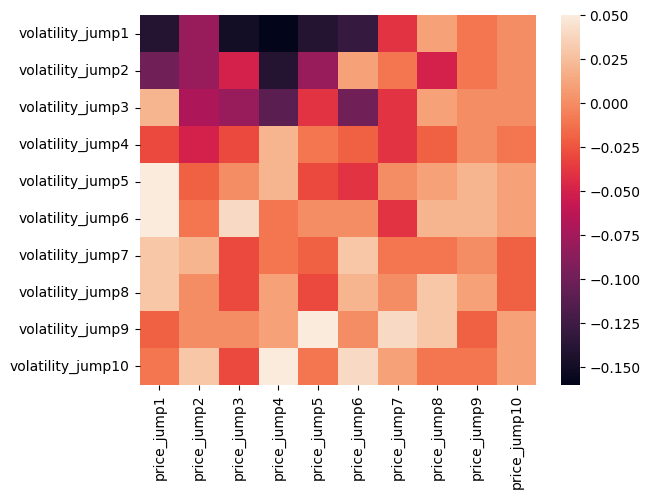

In [102]:
ranking_matrix = [[0] * 10 for _ in range(10)]

# Populate the matrix (for demonstration purposes)
for i in range(10):
    for j in range(10):
            if 'Fisher_test_new' == reshaped_list[i][j][0][0]:
                ranking_matrix[i][j] = reshaped_list[i][j][0][1] - reshaped_list[i][j][1][1]
            elif 'Fisher_test_new' == reshaped_list[i][j][1][0]:
                ranking_matrix[i][j] =  reshaped_list[i][j][1][1] - reshaped_list[i][j][0][1]
            else:
                ranking_matrix[i][j] =  reshaped_list[i][j][2][1] - reshaped_list[i][j][0][1]

column_names = []
row_names = []

for i in range(1, 11):
    column_names.append(f'price_jump{i}')
    row_names.append(f'volatility_jump{i}')
ranking_df = pd.DataFrame(ranking_matrix,columns=column_names, index=row_names)
ranking_df
sns.heatmap(ranking_df, annot = False)
plt.show()

# Normalize Test Statistic Values (x)

In [103]:
def normalized_matrix(matrix_norm):
    m = np.mean(matrix_norm)
    s = np.std(matrix_norm)
    return (matrix_norm - m) / s

dfs_norm = []

for df in dfs:
    # Apply functions to transform each DataFrame
    df_normalized = pd.DataFrame()
    
    # Apply the normalized_matrix function to each column of the DataFrame
    df_normalized = df.iloc[:, :9].apply(normalized_matrix)
    
    dfs_norm.append(df_normalized)

dfs_norm[10]


,BNS,CPR,TMIN,TMED,PZ2,PZ4,ASJ,LM,JO
0,0.486011,0.211576,0.432352,0.731790,-0.363415,-0.328742,-0.891830,-0.734171,0.182967
1,0.862833,1.401753,1.068828,1.682634,-0.307648,-0.313304,-0.952614,-0.103340,2.106832
2,0.280298,-0.070790,0.529707,0.450000,-0.448596,-0.285931,-0.954232,-0.344517,-0.645223
3,1.297131,1.049349,0.841382,1.381021,2.340975,2.376769,-0.825961,0.584318,0.611935
4,1.078958,0.856310,1.004445,0.231071,-0.370331,-0.283494,0.004405,-0.186698,0.204417
...,...,...,...,...,...,...,...,...,...
95,-0.782620,-0.313381,-0.484863,-0.323126,-0.311836,-0.331741,-0.987365,-0.721428,-0.863952
96,-1.125760,-0.108946,-0.878437,-0.374491,-0.360726,-0.323708,0.187406,-0.822625,-0.053117
97,0.116440,0.217562,-0.019263,-0.494239,-0.346213,-0.315830,-0.789847,-0.657269,1.063305
98,-0.095082,-0.154336,0.277146,0.471038,-0.420328,-0.303929,1.587986,-0.924708,0.352933


# Calculate Empirical CDF of Test Values (x)

In [104]:
def transform_data(data):
    
    # Step 1: Compute ECDFs for each column in normalized_matrix
    ecdfs = {}
    for column in data.columns:
        ecdf = sm.distributions.empirical_distribution.ECDF(data[column])
        ecdfs[column] = ecdf

    # Step 2: Apply ECDFs to update the data
    new_p = data.copy()
    for column in data.columns:
        new_p[column] = ecdfs[column](data[column])

    # Step 3: Set new p-value to 0.99999999 if it equals 1
    new_p[new_p == 1] = 0.99999999

    # Step 4: Approximate -2 log cumulative distribution vector for each column
    W = -2 * np.log(1 - new_p)
    
    return W

dfs_W = []  # Initialize list to store transformed DataFrames

# Apply transformation to each DataFrame in dfs_norm
for df_norm in dfs_norm:
    # Transform the current DataFrame
    df_W = transform_data(df_norm)
    
    # Append the transformed DataFrame to dfs_W
    dfs_W.append(df_W)

# dfs_W now contains a list of transformed DataFrames
dfs_W[0]


NameError: name 'sm' is not defined

In [969]:
def transform_data(element):

    element[element == 1] = 0.999
    # Step 4: Approximate -2 log cumulative distribution vector for each column
    W = -2 * np.log(1 - element)
    
    return W

dfs_W = []  # Initialize list to store transformed DataFrames

# Apply transformation to each DataFrame in dfs_norm
for df in dfs_p:
    # Transform the current DataFrame
    df_W = transform_data(df)
    
    # Append the transformed DataFrame to dfs_W
    dfs_W.append(df_W)

# dfs_W now contains a list of transformed DataFrames
dfs_W[50]


,BNS,CPR,TMIN,TMED,PZ2,PZ4,ASJ,LM,JO
0,5.752160,3.731664,4.470010,1.651100,0.145735,0.150374,0.561542,0.118052,3.443384
1,2.598028,0.166503,2.290137,1.612963,2.241522,3.770769,8.360205,2.304857,1.555193
2,0.771221,0.021450,0.429833,0.141901,0.462714,5.309459,0.590886,2.739579,0.213727
3,5.751648,4.611909,6.287678,7.623157,1.145251,2.676585,1.378124,2.244020,2.444360
4,1.054665,0.313138,1.643155,2.034858,0.362258,3.015349,9.637319,0.536028,0.810204
...,...,...,...,...,...,...,...,...,...
995,1.022149,0.075903,0.807538,0.501372,-0.000000,-0.000000,0.914425,2.861786,2.253327
996,7.249098,3.782913,4.711796,1.956100,5.730526,6.016206,8.136384,1.157457,2.141605
997,0.309062,0.110700,0.525066,1.704852,1.968755,0.136127,0.388307,1.559684,0.855562
998,0.207530,0.068137,0.155539,1.814008,1.959309,0.164672,13.532609,0.624592,0.346661


# Calculate Covariance Matrix (x)

In [970]:
# List to store covariance matrices
dfs_cov = []

# Compute covariance matrix for each DataFrame in dfs_W
for df_W in dfs_W:
    covar_matrix = df_W.cov()
    dfs_cov.append(covar_matrix)
dfs_cov[5]

,BNS,CPR,TMIN,TMED,PZ2,PZ4,ASJ,LM,JO
BNS,2.738578,0.811050,2.581619,1.969637,0.685518,0.372041,-2.126139,0.682427,0.633787
CPR,0.811050,0.404856,0.768677,0.585917,0.166470,0.078270,-0.607825,0.179069,0.188369
TMIN,2.581619,0.768677,2.837510,2.282333,0.634405,0.309053,-2.103212,0.631232,0.663591
TMED,1.969637,0.585917,2.282333,2.781855,0.605051,0.412383,-1.845287,0.583430,0.849613
PZ2,0.685518,0.166470,0.634405,0.605051,3.186338,0.838595,-1.730812,0.294790,0.475891
PZ4,0.372041,0.078270,0.309053,0.412383,0.838595,3.192950,-2.009794,0.294595,0.507185
ASJ,-2.126139,-0.607825,-2.103212,-1.845287,-1.730812,-2.009794,105.302353,-1.667629,-1.954950
LM,0.682427,0.179069,0.631232,0.583430,0.294790,0.294595,-1.667629,0.753571,0.232515
JO,0.633787,0.188369,0.663591,0.849613,0.475891,0.507185,-1.954950,0.232515,3.678512


# Convert to matrix from df (x)

In [971]:
# List to store covariance matrices as numpy arrays
dfs_cov_matrix = []

# Compute covariance matrix for each DataFrame in dfs_W
for df_W in dfs_W:
    covar_matrix = df_W.cov().to_numpy()  # Convert DataFrame to numpy array
    dfs_cov_matrix.append(covar_matrix)
dfs_cov_matrix[3]

array([[ 3.5962786 ,  1.04188499,  3.35039711,  2.32372441,  0.44520104,
         0.4356281 , -1.62038729,  0.64941214,  0.39209436],
       [ 1.04188499,  0.55044192,  1.00010197,  0.74959653,  0.11640604,
         0.10826376, -0.45902314,  0.16973518,  0.14201391],
       [ 3.35039711,  1.00010197,  3.65201763,  2.66734956,  0.47512829,
         0.33809894, -1.87669682,  0.57318322,  0.42069765],
       [ 2.32372441,  0.74959653,  2.66734956,  3.55052463,  0.53035978,
         0.28659636, -1.625322  ,  0.60649589,  0.4349898 ],
       [ 0.44520104,  0.11640604,  0.47512829,  0.53035978,  4.36464233,
         0.47558581,  0.16356989,  0.24559205,  0.23057373],
       [ 0.4356281 ,  0.10826376,  0.33809894,  0.28659636,  0.47558581,
         3.25975994, -0.6985043 ,  0.21687105,  0.09894804],
       [-1.62038729, -0.45902314, -1.87669682, -1.625322  ,  0.16356989,
        -0.6985043 , 65.47329157, -0.62631115, -1.03181285],
       [ 0.64941214,  0.16973518,  0.57318322,  0.60649589,  0

## Fisher and Brown P-values (x)

In [972]:
from scipy.stats import chi2
def CombinePValues(covar_matrix, p_values, extra_info = False):
    m = int(covar_matrix.shape[0])
    df_fisher = 2.0*m
    Expected = 2.0*m
    cov_sum = 0
    for i in range(m):
        for j in range(i+1, m):
            cov_sum += covar_matrix[i, j]
        #print "cov sum", cov_sum
    Var = 4.0*m+2*cov_sum
    c = Var/(2.0*Expected)
    df_brown = 2.0*Expected**2/Var
    if df_brown > df_fisher:
        df_brown = df_fisher
        c = 1.0

    x = 2.0 * sum([-np.log(max(p, 1e-10)) for p in p_values])
    #print "x", x
    p_brown = chi2.cdf(df_brown, 1.0*x/c)
    p_fisher = chi2.cdf(df_fisher, 1.0*x)
    
    if extra_info:
        return p_brown, p_fisher, c, df_brown
    else:
        return p_brown, p_fisher
    
results_brown = []
results_fisher = []

# Iterate over each pair of DataFrame (df_p) and NumPy array (df_cov_matrix)
for df_p, cov_matrix in zip(dfs_p, dfs_cov_matrix):
    # Initialize combined results for each pair of DataFrames
    p_brown_list = []
    p_fisher_list = []
    
    # Iterate over each row in the DataFrame
    for idx, row_p in df_p.iterrows():
        p_values = row_p.tolist()
        
        # Call CombinePValues for the current row
        p_brown, p_fisher = CombinePValues(cov_matrix, p_values, extra_info=False)
        
        # Append the results to the respective lists
        p_brown_list.append(p_brown)
        p_fisher_list.append(p_fisher)
    
    # Append the combined results for the current pair of DataFrame and NumPy array to the overall results list
    results_brown.append(p_brown_list)
    results_fisher.append(p_fisher_list)


# Kost's Method (x)

In [ ]:
#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array
#       A vector of m P-values to combine. May be a list or of type numpy.array.
#Output: A combined P-value using Kost's Method.
#        If extra_info == True: also returns the p-value from Fisher's method, the scale factor c, and the new degrees of freedom from Brown's Method
def KostsMethod(data_matrix, p_values, extra_info = False):
    covar_matrix = CalculateKostCovariance(data_matrix)
    return CombinePValues(covar_matrix, p_values, extra_info = extra_info)
    
#Input correlation between two n x n data vectors.
#Output: Kost's approximation of the covariance between the -log cumulative distributions. This is calculated with a cubic polynomial fit.
def KostPolyFit(cor):
    a1, a2, a3 = 3.263, .710, .027 #Kost cubic coeficients
    return a1*cor+a2*cor**2+a3*cor**3
    
#Input: An m x n data matrix with each of m rows representing a variable and each of n columns representing a sample. Should be of type numpy.array.
#       Note: Method does not deal with missing values within the data.
#Output: An m x m matrix of pairwise covariances between the data vectors calculated using Kost's polynomial fit and numpy's pearson correlation function.
def CalculateKostCovariance(data_matrix):
    m = data_matrix.shape[0]
    covar_matrix = np.zeros((m, m))
    for i in range(m):
        for j in range(i+1, m):
            cor, p_val = pearsonr(data_matrix[i, :], data_matrix[j, :])
            covar = KostPolyFit(cor)
            covar_matrix[i, j] = covar
            covar_matrix[j, i] = covar
    return covar_matrix
    

# Cauchy Combination Test (CCT)

In [1]:
import numpy as np

def cauchy_combination_test(p_values, weights=None):
    K = len(p_values)
    if weights is None:
        weights = np.ones(K) / K  # Default: equal weights

    # Compute the Cauchy transformation
    tan_values = np.tan(np.pi * (0.5 - np.array(p_values)))

    # Compute the test statistic
    T = np.sum(weights * tan_values)

    # Compute the final p-value
    combined_p = 0.5 - (1 / np.pi) * np.arctan(T)
    
    return combined_p

# Example Usage
p_values = [0.01, 0.03, 0.05, 0.10]  # Example p-values
cct_p = cauchy_combination_test(p_values)
print(f"Combined p-value: {cct_p}")

Combined p-value: 0.02453555058728507
